# Trabajo Práctico 1 - Entrenamiento de una red de Hopfield (1982)

## Lorenzo Minervino - Padrón: 107863

## 1 - Entrene una red de Hopfield ‘82 con las imágenes binarias disponibles en el campus

### Carga y conversión de imágenes a formato binario

Se define un conjunto de funciones para cargar las imágenes `.bmp` desde una carpeta y convertirlas a matrices binarias de `0` y `1`, donde `1` representa píxeles blancos y `0` píxeles negros. Estas matrices representan los patrones que serán almacenados en la red de Hopfield.


In [1]:
from PIL import Image
import os
import numpy as np

def cargar_imagen_en_binario(ruta, invert=False):
    """
    Abre una imagen ya binaria (0 o 255), la convierte a {0,1}.
    - invert: True para 1=negro, False para 1=blanco
    """
    img = Image.open(ruta).convert("L")  
    arr = np.array(img, dtype=np.uint8) 

    binaria = (arr > 0).astype(np.uint8) 
    if invert:
        binaria = 1 - binaria

    h, w = binaria.shape
    print(f"{os.path.basename(ruta)} - tamaño: {w}x{h}")
    return binaria.tolist()

def cargar_patrones_desde_carpeta(carpeta, invert=False):
    """
    Carga .bmp como patrones binarios {0,1}.
    """
    archivos_bmp = sorted([f for f in os.listdir(carpeta) if f.lower().endswith(".bmp")])
    patrones = []
    for archivo in archivos_bmp:
        ruta_completa = os.path.join(carpeta, archivo)
        patron = cargar_imagen_en_binario(ruta_completa, invert=invert)
        patrones.append(patron)

    if patrones:
        print(f"Se cargaron {len(patrones)} patrones de {len(patrones[0])} filas y {len(patrones[0][0])} columnas cada uno.")
    else:
        print("No se encontraron archivos .bmp en la carpeta.")
    return patrones


### Vectorización y normalización de patrones

En esta etapa se toma cada imagen cargada como una matriz binaria (valores `0` y `1`) y se convierte en un vector unidimensional con valores `-1` y `1`. Esta transformación es necesaria porque la red de Hopfield representa cada patrón como un vector de activaciones, donde los valores deben estar centrados en torno al cero para cumplir con los fundamentos del modelo.

Primero, cada valor `0` se transforma en `-1`, y cada `1` se mantiene. Luego, la matriz bidimensional de la imagen se aplana en un solo vector, lo que permite operar con productos exteriores y aplicar dinámicas de red en forma vectorial.

In [2]:
import numpy as np

import numpy as np

def centrar_y_vectorizar_patrones(patrones, invert=False):
    """
    Convierte patrones binarios {0,1} (P,h,w) en vectores {-1,+1} (P,N)
    """
    arr = np.asarray(patrones)
    if arr.size == 0:
        print("Tengo 0 patrones vectorizados de 0 elementos cada uno.")
        return arr.reshape(0, 0).astype(np.int8)

    if arr.ndim == 2: 
        arr = arr[None, ...]

    if invert:
        arr = 1 - arr

    X = arr.reshape(arr.shape[0], -1) 
    Xpm1 = (X * 2 - 1).astype(np.int8) 
    return Xpm1


carpeta_imagenes = "imagenes/50x50"
patrones = cargar_patrones_desde_carpeta(carpeta_imagenes)
patrones_originales = patrones  
patrones_vectorizados = centrar_y_vectorizar_patrones(patrones) 

print("Tengo " + str(len(patrones_vectorizados)) +
      " patrones vectorizados de " + str(len(patrones_vectorizados[0])) +
      " elementos cada uno.")


panda.bmp - tamaño: 50x50
perro.bmp - tamaño: 50x50
v.bmp - tamaño: 50x50
Se cargaron 3 patrones de 50 filas y 50 columnas cada uno.
Tengo 3 patrones vectorizados de 2500 elementos cada uno.


### Inicialización de la matriz de pesos

Antes de entrenar la red de Hopfield, se debe crear la matriz de pesos sinápticos `W`, que define las conexiones entre neuronas. Esta matriz es cuadrada y tiene dimensiones `N × N`, donde `N` es la cantidad total de píxeles (o neuronas) por patrón.

Inicialmente, todos los pesos se establecen en cero, y luego se actualizarán mediante la regla de Hebb durante el entrenamiento. Esta matriz almacena el conocimiento aprendido por la red.


In [3]:

def inicializar_matriz_pesos(dimension, dtype=np.float32):
    """
    Inicializa una matriz cuadrada de pesos de tamaño NxN con ceros.
    """
    return np.zeros((dimension, dimension), dtype=dtype)

ancho = 50
alto = 50
dimension = ancho * alto  # 2500

pesos = inicializar_matriz_pesos(dimension)
print(f"mis pesos tienen la dimensión: {len(pesos)}x{len(pesos[0])}")

mis pesos tienen la dimensión: 2500x2500


### Entrenamiento de la red de Hopfield

La red de Hopfield se entrena utilizando la **regla de Hebb**, una regla de aprendizaje no supervisado que refuerza las conexiones entre neuronas que se activan simultáneamente. En esta implementación, se recorren todos los patrones vectorizados y se calcula la **suma de los productos exteriores** de cada patrón consigo mismo.

El resultado es una matriz de pesos sinápticos que almacena la información de los patrones aprendidos. Finalmente, se eliminan las autoconexiones (valores en la diagonal) ya que una neurona no debe influenciarse a sí misma.

In [4]:
import numpy as np

def entrenar_red_hopfield(patrones_vectorizados, norm='N'):
    """
    Entrena Hopfield con patrones en {-1, +1} (acepta también {0,1} y los convierte).
    Retorna W (N, N) float32, diagonal = 0.
    
    norm: 'N' -> divide por N (clásico Hopfield)
          'P' -> divide por P (otra alternativa)
    """
    X = np.asarray(patrones_vectorizados)
    if X.ndim == 1:
        X = X[None, :]

    u = np.unique(X)
    uset = set(u.tolist())
    if uset.issubset({0, 1}):
        X = (X.astype(np.int16) * 2 - 1).astype(np.int8)
    elif not uset.issubset({-1, 1}):
        X = np.where(X > 0, 1, -1).astype(np.int8)

    X = X.astype(np.float32, copy=False)
    P, N = X.shape

    W = X.T @ X
    if norm == 'N':
        W /= float(N)
    elif norm == 'P':
        W /= float(P)
    else:
        raise ValueError("norm debe ser 'N' o 'P'.")

    np.fill_diagonal(W, 0.0)
    return W

pesos = entrenar_red_hopfield(patrones_vectorizados, norm='N') 
print(f"Matriz de pesos entrenada con tamaño: {len(pesos)}x{len(pesos[0])}")


Matriz de pesos entrenada con tamaño: 2500x2500


In [5]:
def recuperar_patron(patron_inicial, pesos, max_iter=100, rng=None, tolerancia=0):
    """
    Recupera un patrón aplicando actualización asíncrona hasta converger.
    
    Parámetros
    ----------
    patron_inicial : array-like (N,)
        Estado inicial en {-1, +1}.
    pesos : np.ndarray (N, N)
        Matriz de pesos (float), idealmente con diagonal en 0.
    max_iter : int
        Máximo de barridos asíncronos completos.
    rng : np.random.Generator | None
        Generador para reproducibilidad. Si None, se crea uno por defecto.
    tolerancia : float
        Tolerancia de convergencia; si no hay cambios significativos en el patrón, se considera convergido.
    """
    W = np.asarray(pesos)
    estado = np.asarray(patron_inicial, dtype=np.int8).copy()
    N = estado.size
    if rng is None:
        rng = np.random.default_rng()

    for _ in range(max_iter):
        cambios = 0
        for i in rng.permutation(N):  # orden aleatorio en cada barrido
            h = W[i].dot(estado)
            nuevo = 1 if h >= 0 else -1
            if estado[i] != nuevo:
                estado[i] = nuevo
                cambios += 1
        
        # Si no hubo cambios o los cambios son menores a la tolerancia, consideramos que convergió
        if cambios <= tolerancia:
            break

    return estado


Representación visual para comparar el patrón de entrada y el que recuperó

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def mostrar_comparacion_patron(original, recuperado, ancho, alto, indice=0):
    ori = np.asarray(original).reshape(alto, ancho)
    rec = np.asarray(recuperado).reshape(alto, ancho)
    
    if ori.min() < 0 or rec.min() < 0:
        ori_show = (ori + 1) / 2.0
        rec_show = (rec + 1) / 2.0
    else:
        ori_show, rec_show = ori, rec

    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(ori_show, cmap='gray', vmin=0, vmax=1)
    axs[0].set_title(f"Original")
    axs[0].axis('off')

    axs[1].imshow(rec_show, cmap='gray', vmin=0, vmax=1)
    axs[1].set_title(f"Recuperado")
    axs[1].axis('off')

    plt.suptitle(f"Comparación patrón {indice}")
    plt.tight_layout()
    plt.show()


## 1.a - Verifique si la red aprendió las imágenes enseñadas.

### Evaluación de recuperación sin ruido

En este paso se verifica si la red de Hopfield es capaz de recuperar correctamente los patrones originales que fueron utilizados durante el entrenamiento. Para ello, cada patrón se usa como entrada inicial y se aplica la dinámica de la red hasta que converge a un estado estable.

Si el estado final es idéntico al patrón original, se considera que la recuperación fue exitosa. Esto demuestra que la red ha almacenado correctamente los patrones en su memoria asociativa.


El patrón 0 fue recuperado correctamente.


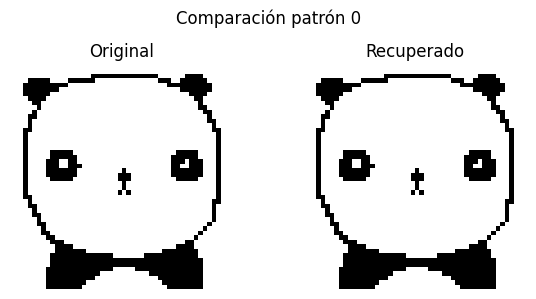

El patrón 1 fue recuperado correctamente.


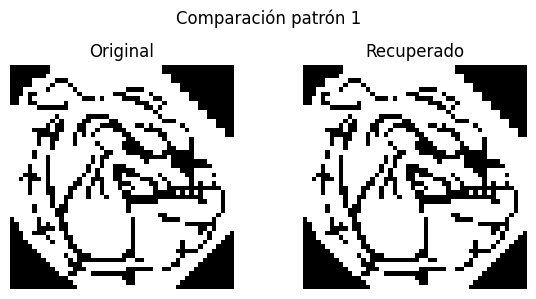

El patrón 2 fue recuperado correctamente.


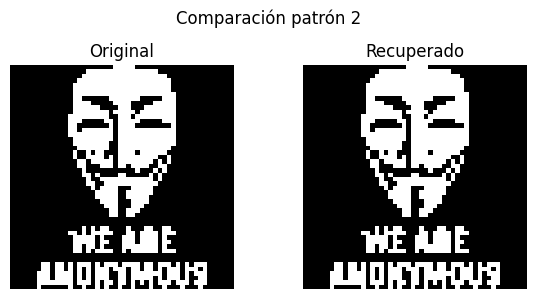

In [7]:
for i in range(len(patrones_vectorizados)):
   
    patron_original = patrones_vectorizados[i];
    estado_convergido = recuperar_patron(patron_original, pesos, max_iter=10000)

    if np.array_equal(estado_convergido, patron_original):
        print(f"El patrón {i} fue recuperado correctamente.")
    else:
        print(f"El patrón {i} NO se recuperó correctamente.")
    mostrar_comparacion_patron(patron_original, estado_convergido, ancho=50, alto=50, indice=i)


### Prueba con imágenes de 60x45

Se repite el procedimiento anterior utilizando un nuevo conjunto de imágenes de tamaño `60x45`. Se cargan, vectorizan y entrenan en la red de Hopfield. Luego, se verifica si la red es capaz de recuperar correctamente los patrones a partir de sí mismos.

Cada comparación muestra el patrón original y su versión recuperada tras aplicar la dinámica de la red. Esto permite verificar que el modelo puede escalar y seguir funcionando correctamente con imágenes más grandes.


paloma.bmp - tamaño: 60x45
quijote.bmp - tamaño: 60x45
torero.bmp - tamaño: 60x45
Se cargaron 3 patrones de 45 filas y 60 columnas cada uno.
El patrón 0 fue recuperado correctamente.


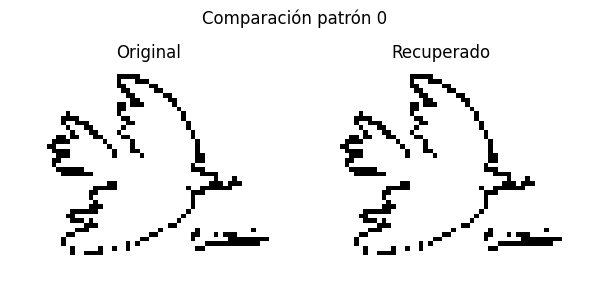

El patrón 1 fue recuperado correctamente.


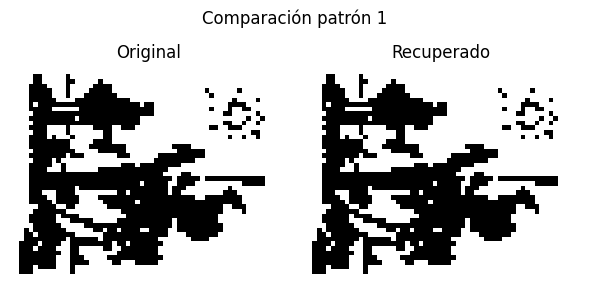

El patrón 2 fue recuperado correctamente.


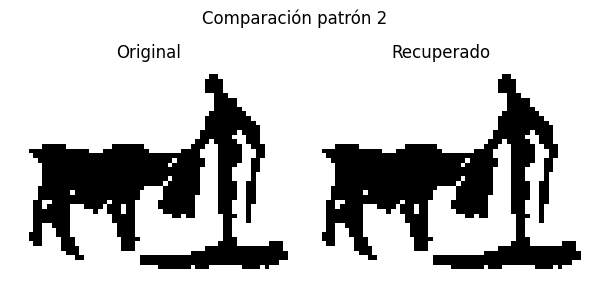

In [8]:
carpeta_imagenes = "imagenes/60x45"
patrones = cargar_patrones_desde_carpeta(carpeta_imagenes) 
patrones_vectorizados_imagenes_grandes = centrar_y_vectorizar_patrones(patrones)  

ancho = 60
alto = 45
dimension = ancho * alto  

pesos_imagenes_grandes = entrenar_red_hopfield(patrones_vectorizados_imagenes_grandes, norm='N')

for i in range(patrones_vectorizados_imagenes_grandes.shape[0]):
    patron_original = patrones_vectorizados_imagenes_grandes[i]                  # (N,)
    estado_convergido = recuperar_patron(patron_original, pesos_imagenes_grandes, max_iter=10000)

    if np.array_equal(estado_convergido, patron_original):
        print(f"El patrón {i} fue recuperado correctamente.")
    else:
        print(f"El patrón {i} NO se recuperó correctamente.")

    mostrar_comparacion_patron(patron_original, estado_convergido, ancho=ancho, alto=alto, indice=i)


### Conclusión: entrenamiento con 3 imágenes

Se entrenó la red de Hopfield con un conjunto reducido de 3 imágenes binarias. La red logró recuperar todos los patrones correctamente, lo que demuestra que, con un número limitado de patrones bien diferenciados, el modelo puede almacenar y recordar eficazmente la información sin interferencia.


## 1.b - Evalúe la evolución de la red al presentarle versiones alteradas de las imágenes aprendidas: agregado de ruido, elementos borrados o agregados.

### Agregado de ruido a los patrones

Para evaluar la robustez de la red de Hopfield, se introduce ruido artificial en los patrones antes de presentarlos a la red. La función `agregar_ruido` invierte aleatoriamente un porcentaje de los bits del patrón original (valores `-1` o `1`).

Este proceso simula entradas incompletas o corruptas, y permite comprobar si la red es capaz de recuperar el patrón correcto a pesar del ruido. La proporción de bits alterados se controla mediante el parámetro `porcentaje_ruido`, que puede variar entre `0.0` (sin ruido) y `1.0` (ruido total).


In [9]:
def agregar_ruido(patron, porcentaje_ruido, rng=None):
    """
    Invierte exactamente floor(n * porcentaje_ruido) bits de un patrón en {-1,+1}.
    
    Parámetros
    ----------
    patron : array-like (N,) o (h,w)
        El patrón original en {-1, +1} o en {0, 1}.
    porcentaje_ruido : 0..1
        El porcentaje de bits a invertir.
    rng : np.random.Generator opcional para reproducibilidad
        Generador de números aleatorios.
    """
    # Asegura que los valores estén en {-1, +1}
    x = np.asarray(patron)
    shape = x.shape
    x = x.astype(np.int8, copy=True).ravel()

    # Si los valores no están en {-1, +1}, los normalizamos
    if np.any((x != -1) & (x != 1)):
        x = np.where(x > 0, 1, -1)

    n = x.size
    k = int(n * porcentaje_ruido)
    if k <= 0:
        return x.reshape(shape)

    rng = rng or np.random.default_rng()
    idx = rng.choice(n, size=k, replace=False)  # Selección de índices aleatorios
    x[idx] *= -1  # Invertir los bits seleccionados
    return x.reshape(shape)



In [10]:
def contar_diferencias(p1, p2):
    """
    Cuenta cuántos bits difieren entre dos patrones del mismo tamaño.
    """
    a = np.asarray(p1)
    b = np.asarray(p2)
    if a.shape != b.shape:
        raise ValueError(f"Formas distintas: {a.shape} vs {b.shape}")
    return int(np.count_nonzero(a != b))


### Evaluación de la tolerancia al ruido

En esta sección se analiza la capacidad de la red de Hopfield para recuperar correctamente los patrones originales a medida que se introduce ruido. Para ello, se prueba con distintos niveles de ruido (de 0% a 100%) invirtiendo aleatoriamente un porcentaje de los bits en cada patrón.

Se calcula el error promedio de recuperación (proporción de bits incorrectos) para cada nivel de ruido. Finalmente, se grafica la precisión de la red como función del ruido, lo cual permite visualizar su comportamiento frente a distorsiones crecientes.

Un buen modelo debería mantener alta precisión para bajos niveles de ruido, degradándose progresivamente a medida que la distorsión aumenta.


In [11]:
import numpy as np
import matplotlib.pyplot as plt

def evaluar_robustez_ruido(patrones_vectorizados, pesos, niveles_ruido=None,
                           max_iter=10000, modo_ruido='exact', rng=None):
    """
    Evalúa el desempeño de la red de Hopfield ante distintos niveles de ruido.

    Parámetros
    ----------
    patrones_vectorizados : (P,N) array-like en {-1,+1} (o convertible)
    pesos : (N,N) np.ndarray
    niveles_ruido : iterable de floats en [0,1]; por defecto [0.0, 0.1, ..., 1.0]
    max_iter : int, iteraciones para la convergencia (recuperación asíncrona)
    modo_ruido : 'exact' (invierte exactamente floor(p*N) bits por patrón) 
                 'bernoulli' (cada bit se invierte con probabilidad p; más rápido)
    rng : np.random.Generator para reproducibilidad

    Retorna
    -------
    niveles_ruido (list[float]), errores_promedio (list[float])
    """
    if niveles_ruido is None:
        niveles_ruido = [i / 10 for i in range(11)]  # 0.0 ... 1.0

    X = np.asarray(patrones_vectorizados)
    if X.ndim == 1:
        X = X[None, :]
    U = set(np.unique(X).tolist())
    if U.issubset({0, 1}):
        X = (X.astype(np.int16)*2 - 1).astype(np.int8)
    elif not U.issubset({-1, 1}):
        X = np.where(X > 0, 1, -1).astype(np.int8)

    P, N = X.shape
    errores_promedio = []
    rng = rng or np.random.default_rng()

    for ruido in niveles_ruido:
        total_errores = 0

        if modo_ruido == 'bernoulli':
            mask = rng.random(size=(P, N)) < float(ruido)
            X_ruidoso = X.copy()
            X_ruidoso[mask] *= -1

            for p in range(P):
                estado_convergido = recuperar_patron(X_ruidoso[p], pesos, max_iter=max_iter)
                total_errores += int(np.count_nonzero(estado_convergido != X[p]))

        else: 
            for p in range(P):
                x_noisy = agregar_ruido(X[p], ruido, rng=rng) 
                estado_convergido = recuperar_patron(x_noisy, pesos, max_iter=max_iter)
                total_errores += int(np.count_nonzero(estado_convergido != X[p]))
                if total_errores == 2500:
                    # Imprimir el patrón recuperado y la comparación con el patrón original
                    print("Estado convergido:", estado_convergido)
                    print("Comparación con el patrón original:", estado_convergido != X[p])

                    # Contar cuántos 1 y -1 hay en el estado convergido
                    num_1_convergido = np.count_nonzero(estado_convergido == 1)
                    num_neg_1_convergido = np.count_nonzero(estado_convergido == -1)

                    # Contar cuántos 1 y -1 hay en el patrón original
                    num_1_original = np.count_nonzero(X[p] == 1)
                    num_neg_1_original = np.count_nonzero(X[p] == -1)

                    # Imprimir los resultados
                    print(f"Estado convergido tiene {num_1_convergido} veces 1 y {num_neg_1_convergido} veces -1")
                    print(f"Patrón original tiene {num_1_original} veces 1 y {num_neg_1_original} veces -1")
                    
                    # Verificar si el estado convergido es completamente opuesto al patrón original
                    if np.array_equal(estado_convergido, -X[p]):
                        print("El estado convergido es completamente el opuesto al patrón original.")
                    else:
                        print("El estado convergido NO es completamente el opuesto al patrón original.")
            promedio = total_errores / (P * N)
            errores_promedio.append(promedio)
            print(f"Ruido {int(ruido*100)}% → Error promedio: {promedio:.4f}")

    return niveles_ruido, errores_promedio


def graficar_precision_vs_ruido(niveles_ruido, errores_promedio):
    """
    Grafica la precisión de recuperación en función del nivel de ruido.
    precisión = 1 - error_promedio
    """
    niveles_ruido = list(niveles_ruido)
    errores_promedio = list(errores_promedio)
    precisiones = [1 - e for e in errores_promedio]

    plt.figure(figsize=(8, 4))
    plt.plot([r * 100 for r in niveles_ruido], precisiones, marker='o', linestyle='-')
    plt.title("Precisión de recuperación vs. nivel de ruido")
    plt.xlabel("Porcentaje de ruido (%)")
    plt.ylabel("Precisión de recuperación")
    plt.ylim(0, 1.05)
    plt.grid(True, alpha=0.3)
    plt.show()


# Imaganes 50x50

Ruido 0% → Error promedio: 0.0000
Ruido 10% → Error promedio: 0.0000
Ruido 20% → Error promedio: 0.0000
Ruido 30% → Error promedio: 0.0000
Ruido 40% → Error promedio: 0.0000
Ruido 50% → Error promedio: 0.4703
Estado convergido: [-1 -1 -1 ... -1 -1 -1]
Comparación con el patrón original: [ True  True  True ...  True  True  True]
Estado convergido tiene 490 veces 1 y 2010 veces -1
Patrón original tiene 2010 veces 1 y 490 veces -1
El estado convergido es completamente el opuesto al patrón original.
Ruido 60% → Error promedio: 1.0000
Estado convergido: [-1 -1 -1 ... -1 -1 -1]
Comparación con el patrón original: [ True  True  True ...  True  True  True]
Estado convergido tiene 490 veces 1 y 2010 veces -1
Patrón original tiene 2010 veces 1 y 490 veces -1
El estado convergido es completamente el opuesto al patrón original.
Ruido 70% → Error promedio: 1.0000
Estado convergido: [-1 -1 -1 ... -1 -1 -1]
Comparación con el patrón original: [ True  True  True ...  True  True  True]
Estado convergid

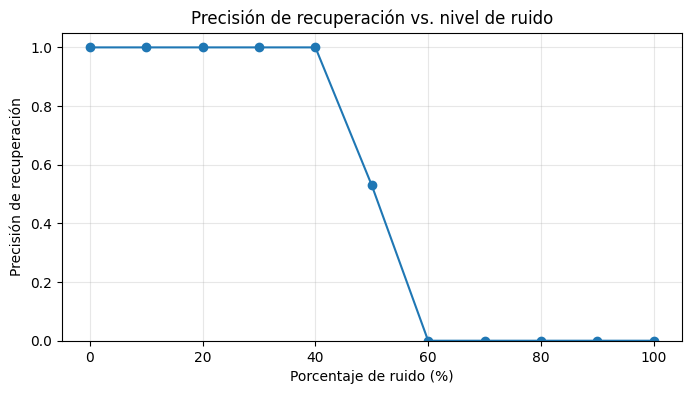

In [12]:
niveles, errores = evaluar_robustez_ruido(patrones_vectorizados, pesos, max_iter=1000)
graficar_precision_vs_ruido(niveles, errores)


# Imagenes 60x45

Ruido 0% → Error promedio: 0.0000
Ruido 10% → Error promedio: 0.0000
Ruido 20% → Error promedio: 0.0000
Ruido 30% → Error promedio: 0.0000
Ruido 40% → Error promedio: 0.0000
Ruido 50% → Error promedio: 0.4752
Ruido 60% → Error promedio: 1.0000
Ruido 70% → Error promedio: 1.0000
Ruido 80% → Error promedio: 1.0000
Ruido 90% → Error promedio: 1.0000
Ruido 100% → Error promedio: 1.0000


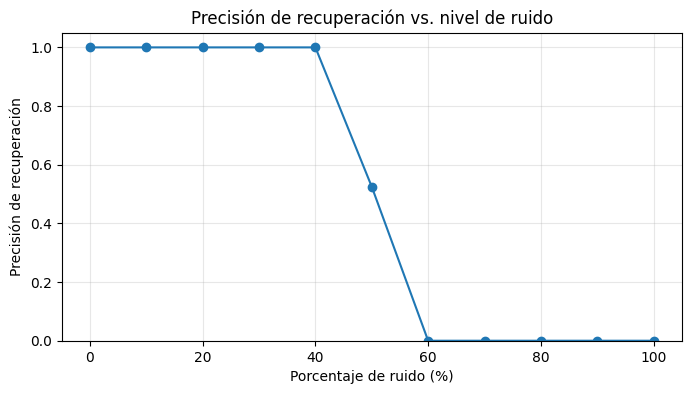

In [13]:
niveles, errores = evaluar_robustez_ruido(patrones_vectorizados_imagenes_grandes, pesos_imagenes_grandes)
graficar_precision_vs_ruido(niveles, errores)


## 1.c - Evalúe la existencia de estados espurios en la red: patrones inversos y combinaciones de un número impar de patrones. 

### Evaluación de estados espurios

En esta celda se prueba la existencia de **estados espurios** en la red de Hopfield entrenada:

- **Patrones invertidos**: se invierte el signo de todos los bits de cada patrón entrenado y se comprueba si el estado permanece estable.
- **Combinaciones impares**: se evalúa la estabilidad del estado resultante de aplicar `sign(P0 + P1 + P2)`.

Si estos estados convergen a sí mismos al ser presentados como entrada a la red, se considera que son **estados espurios estables**. Esta es una propiedad conocida de las redes de Hopfield, especialmente cuando se usan múltiples patrones y hay solapamiento entre ellos.


Por último, se evalúa la existencia de estados espurios del tipo **spin-glass**, que son mínimos locales de la energía que **no se parecen a ningún patrón almacenado** ni a combinaciones de ellos.

Para esto, se generan vectores aleatorios de activación (`-1` y `1`) que actúan como entradas completamente nuevas. Si la red converge a esos mismos estados sin haberlos aprendido, se considera que son **estados espurios del tipo spin-glass**.

Este fenómeno se vuelve más probable a medida que se entrena la red con un mayor número de patrones, lo cual genera interferencias y reduce la capacidad efectiva de almacenamiento.

paloma.bmp - tamaño: 60x45
quijote.bmp - tamaño: 60x45
torero.bmp - tamaño: 60x45
Se cargaron 3 patrones de 45 filas y 60 columnas cada uno.

--- Estados inversos ---
Inverso del patrón 0 es un estado espurio estable.


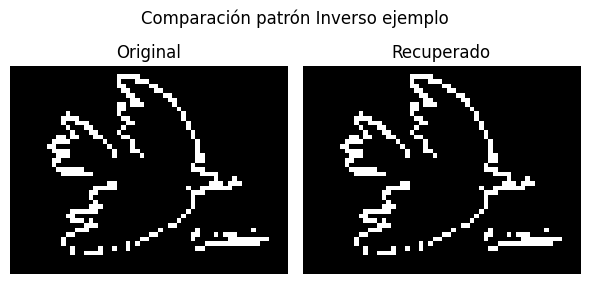

Inverso del patrón 1 es un estado espurio estable.


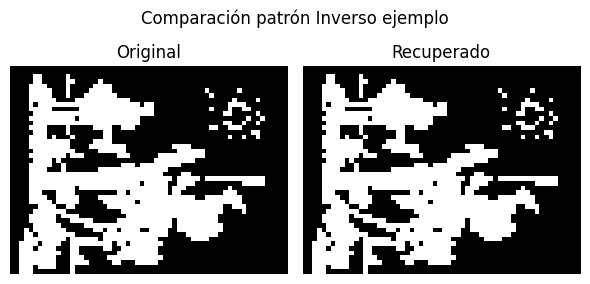

Inverso del patrón 2 es un estado espurio estable.


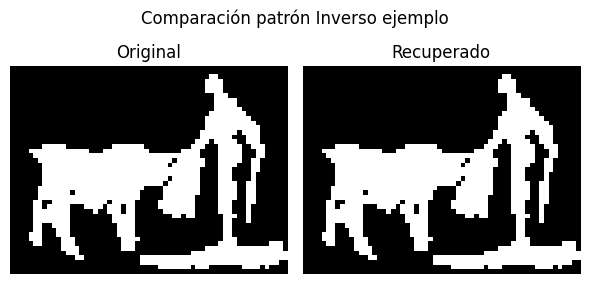


--- Combinación impar de 3 patrones: todas las ± ---
Combinación +P0 +P1 +P2: ESPURIO


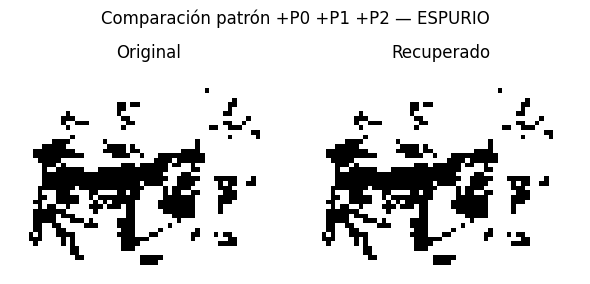

Combinación +P0 +P1 -P2: ESPURIO


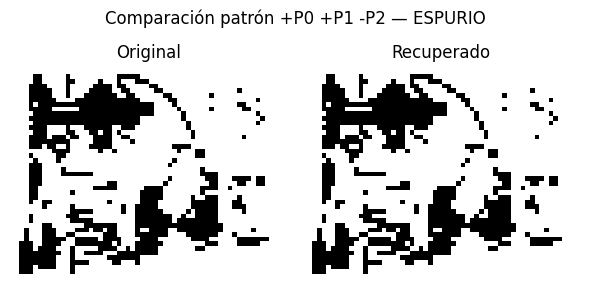

Combinación +P0 -P1 +P2: ESPURIO


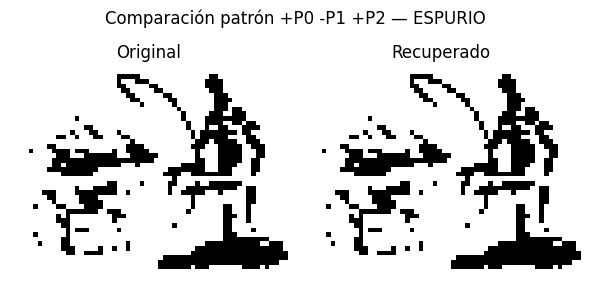

Combinación +P0 -P1 -P2: ESPURIO


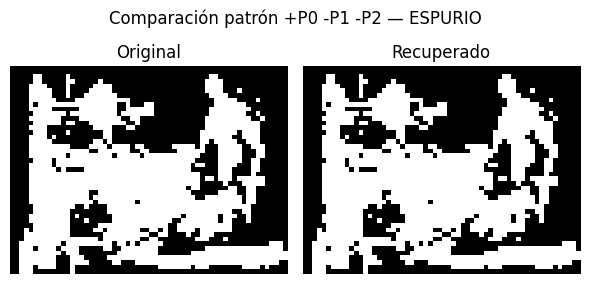

Combinación -P0 +P1 +P2: ESPURIO


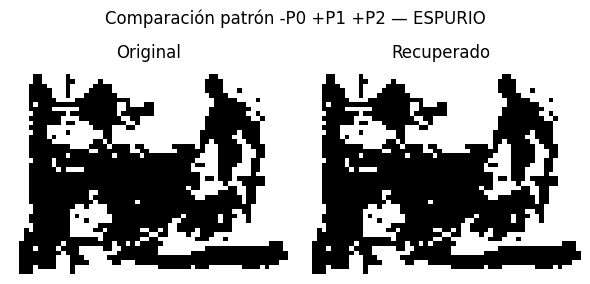

Combinación -P0 +P1 -P2: ESPURIO


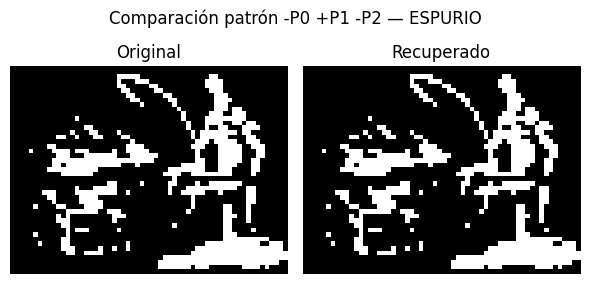

Combinación -P0 -P1 +P2: ESPURIO


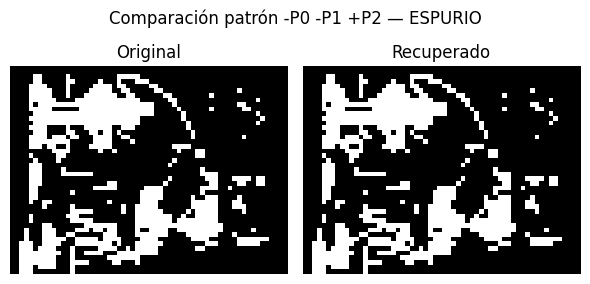

Combinación -P0 -P1 -P2: ESPURIO


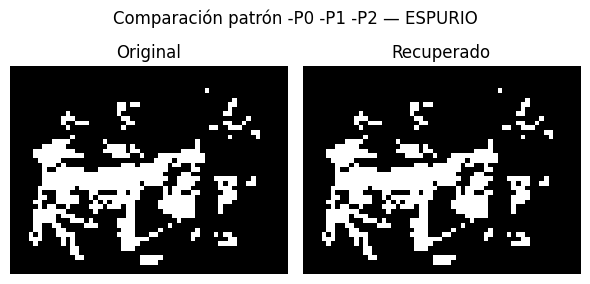


--- Estados tipo spin-glass ---
Estado aleatorio 0 NO es estable.
Estado aleatorio 1 NO es estable.
Estado aleatorio 2 NO es estable.
Estado aleatorio 3 NO es estable.
Estado aleatorio 4 NO es estable.


In [14]:
carpeta_imagenes = "imagenes/60x45"
patrones = cargar_patrones_desde_carpeta(carpeta_imagenes)            
patrones_vectorizados = centrar_y_vectorizar_patrones(patrones)        

ancho, alto = 60, 45
dimension = ancho * alto

pesos = entrenar_red_hopfield(patrones_vectorizados)                

def es_estable(estado, pesos, max_iter=10000):
    """
    Verifica si un estado es un mínimo estable (converge a sí mismo).
    """
    estado = np.asarray(estado, dtype=np.int8).ravel()
    convergido = recuperar_patron(estado, pesos, max_iter=max_iter)
    return np.array_equal(convergido, estado)

# 1) Inversos de cada patrón
print("\n--- Estados inversos ---")
for i in range(patrones_vectorizados.shape[0]):
    patron = patrones_vectorizados[i]
    inverso = (-patron).astype(np.int8, copy=False)
    if es_estable(inverso, pesos):
        print(f"Inverso del patrón {i} es un estado espurio estable.")
    else:
        print(f"Inverso del patrón {i} NO es estable.")
    rec_inv = recuperar_patron(inverso, pesos, max_iter=10000)
    mostrar_comparacion_patron(inverso, rec_inv, ancho, alto, indice="Inverso ejemplo")

# 2) Combinación impar de 3 patrones: TODAS las ± (sign(P0 ± P1 ± P2))
print("\n--- Combinación impar de 3 patrones: todas las ± ---")

if patrones_vectorizados.shape[0] >= 3:
    # Elegí los 3 que quieras (acá uso 0,1,2)
    i0, i1, i2 = 0, 1, 2
    P0 = patrones_vectorizados[i0]
    P1 = patrones_vectorizados[i1]
    P2 = patrones_vectorizados[i2]

    # Todas las combinaciones de signos
    S = np.array([
        [ +1, +1, +1],
        [ +1, +1, -1],
        [ +1, -1, +1],
        [ +1, -1, -1],
        [ -1, +1, +1],
        [ -1, +1, -1],
        [ -1, -1, +1],
        [ -1, -1, -1],
    ], dtype=np.int8)

    def etiqueta_signos(row):
        return " ".join([
            ("+P0" if row[0] == 1 else "-P0"),
            ("+P1" if row[1] == 1 else "-P1"),
            ("+P2" if row[2] == 1 else "-P2"),
        ])

   
    P_stack = np.stack([P0, P1, P2], axis=0).astype(np.int16)   
    comb_sum = S @ P_stack                                     
    combos = np.where(comb_sum >= 0, 1, -1).astype(np.int8)   

    for row, estado in zip(S, combos):
        rec = recuperar_patron(estado, pesos, max_iter=10000)
        estable = np.array_equal(rec, estado)
        print(f"Combinación {etiqueta_signos(row)}: {'ESPURIO' if estable else 'NO estable'}")
        mostrar_comparacion_patron(
            estado, rec, ancho, alto,
            indice=f"{etiqueta_signos(row)} — {'ESPURIO' if estable else 'NO estable'}"
        )
else:
    print("No hay suficientes patrones para probar combinación impar.")

# 3) Estados tipo spin-glass: aleatorios, no relacionados
print("\n--- Estados tipo spin-glass ---")
rng = np.random.default_rng(123)

def generar_estado_aleatorio(n, rng=None):
    rng = rng or np.random.default_rng()
    return np.where(rng.integers(0, 2, size=n, dtype=np.int8)==0, -1, 1).astype(np.int8)

for i in range(5):  # probar 5 estados aleatorios
    estado_random = generar_estado_aleatorio(dimension, rng=rng)
    if es_estable(estado_random, pesos):
        print(f"Estado aleatorio {i} es un mínimo local estable (posible spin-glass).")
    else:
        print(f"Estado aleatorio {i} NO es estable.")


panda.bmp - tamaño: 50x50
perro.bmp - tamaño: 50x50
v.bmp - tamaño: 50x50
Se cargaron 3 patrones de 50 filas y 50 columnas cada uno.

--- Estados inversos ---
Inverso del patrón 0 es un estado espurio estable.


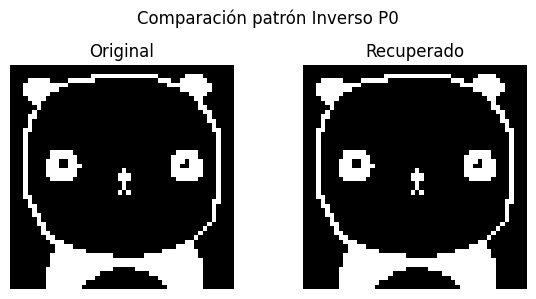

Inverso del patrón 1 es un estado espurio estable.


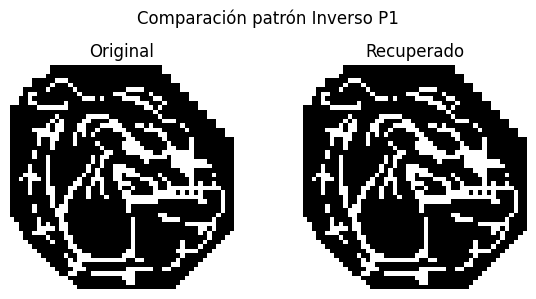

Inverso del patrón 2 es un estado espurio estable.


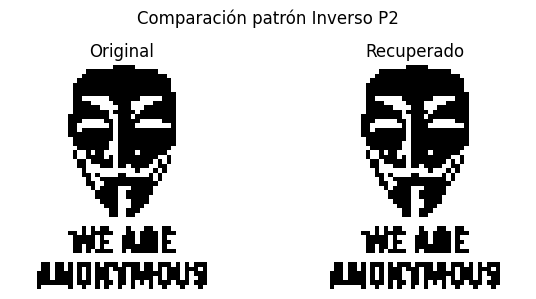


--- Combinación impar de 3 patrones: todas las ± ---
Combinación +P0 +P1 +P2: ESPURIO


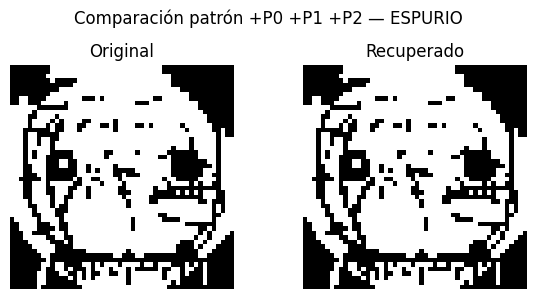

Combinación +P0 +P1 -P2: ESPURIO


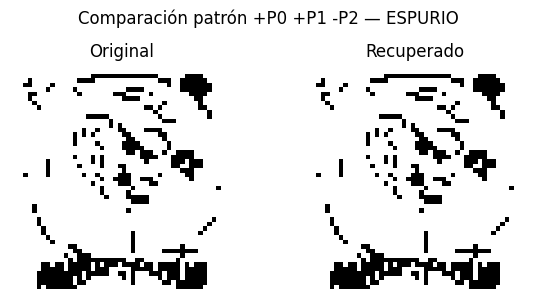

Combinación +P0 -P1 +P2: ESPURIO


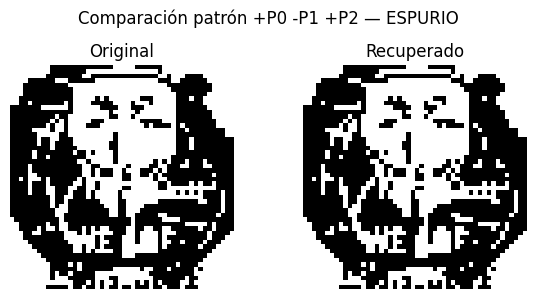

Combinación +P0 -P1 -P2: ESPURIO


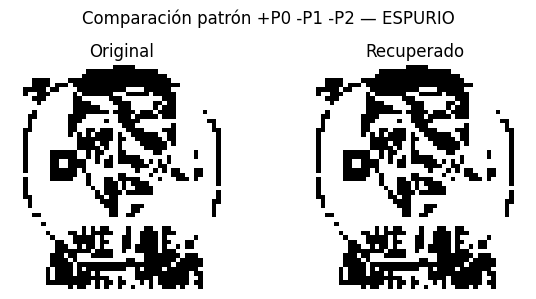

Combinación -P0 +P1 +P2: ESPURIO


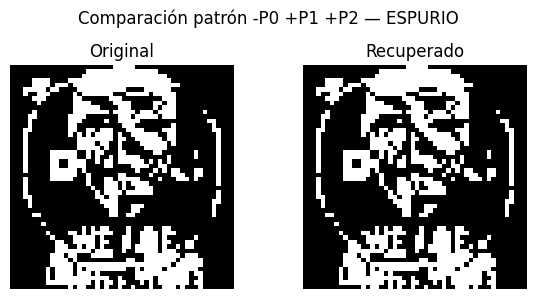

Combinación -P0 +P1 -P2: ESPURIO


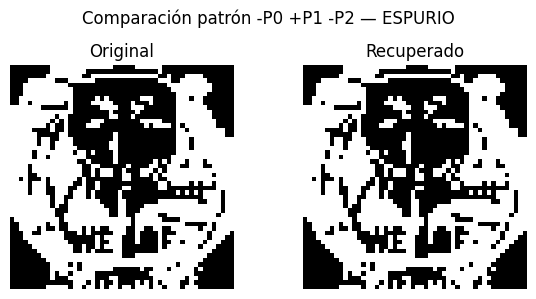

Combinación -P0 -P1 +P2: ESPURIO


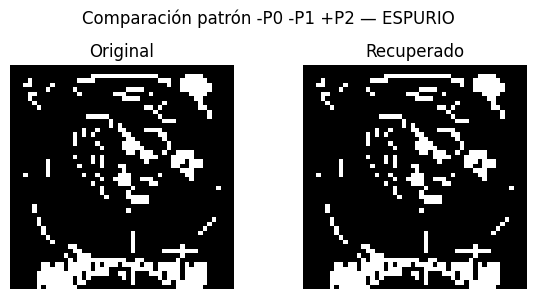

Combinación -P0 -P1 -P2: ESPURIO


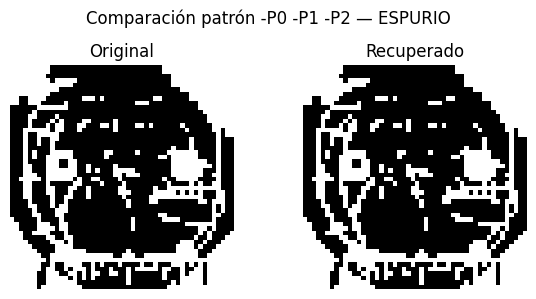


--- Estados tipo spin-glass ---
Estado aleatorio 0 NO es estable.
Estado aleatorio 1 NO es estable.
Estado aleatorio 2 NO es estable.
Estado aleatorio 3 NO es estable.
Estado aleatorio 4 NO es estable.


In [15]:
carpeta_imagenes = "imagenes/50x50"
patrones = cargar_patrones_desde_carpeta(carpeta_imagenes)             
patrones_vectorizados = centrar_y_vectorizar_patrones(patrones)       

ancho, alto = 50, 50
dimension = ancho * alto

# Entrenar la red
pesos = entrenar_red_hopfield(patrones_vectorizados)                   

# ---------- ESTADOS ESPURIOS ----------

# 1) Inversos de cada patrón
print("\n--- Estados inversos ---")
for i in range(patrones_vectorizados.shape[0]):
    patron = patrones_vectorizados[i]
    inverso = (-patron).astype(np.int8, copy=False)
    if es_estable(inverso, pesos):
        print(f"Inverso del patrón {i} es un estado espurio estable.")
    else:
        print(f"Inverso del patrón {i} NO es estable.")
    rec_inv = recuperar_patron(inverso, pesos, max_iter=10000)
    mostrar_comparacion_patron(inverso, rec_inv, ancho, alto, indice=f"Inverso P{i}")

# 2) Combinación impar de 3 patrones: TODAS las ± (sign(P0 ± P1 ± P2))
print("\n--- Combinación impar de 3 patrones: todas las ± ---")

if patrones_vectorizados.shape[0] >= 3:
    # Elegí los 3 que quieras (acá uso 0,1,2)
    i0, i1, i2 = 0, 1, 2
    P0 = patrones_vectorizados[i0]
    P1 = patrones_vectorizados[i1]
    P2 = patrones_vectorizados[i2]

    # Todas las combinaciones de signos
    S = np.array([
        [ +1, +1, +1],
        [ +1, +1, -1],
        [ +1, -1, +1],
        [ +1, -1, -1],
        [ -1, +1, +1],
        [ -1, +1, -1],
        [ -1, -1, +1],
        [ -1, -1, -1],
    ], dtype=np.int8)

    def etiqueta_signos(row):
        return " ".join([
            ("+P0" if row[0] == 1 else "-P0"),
            ("+P1" if row[1] == 1 else "-P1"),
            ("+P2" if row[2] == 1 else "-P2"),
        ])

    P_stack = np.stack([P0, P1, P2], axis=0).astype(np.int16)   
    comb_sum = S @ P_stack                                     
    combos = np.where(comb_sum >= 0, 1, -1).astype(np.int8)     

    for row, estado in zip(S, combos):
        rec = recuperar_patron(estado, pesos, max_iter=10000)
        estable = np.array_equal(rec, estado)
        print(f"Combinación {etiqueta_signos(row)}: {'ESPURIO' if estable else 'NO estable'}")
        mostrar_comparacion_patron(
            estado, rec, ancho, alto,
            indice=f"{etiqueta_signos(row)} — {'ESPURIO' if estable else 'NO estable'}"
        )
else:
    print("No hay suficientes patrones para probar combinación impar (se necesitan al menos 3).")

# 3) Estados tipo spin-glass: aleatorios, no relacionados
print("\n--- Estados tipo spin-glass ---")
rng = np.random.default_rng(123)

def generar_estado_aleatorio(n, rng=None):
    rng = rng or np.random.default_rng()
    return np.where(rng.integers(0, 2, size=n, dtype=np.int8)==0, -1, 1).astype(np.int8)

for i in range(5):  # probar 5 estados aleatorios
    estado_random = generar_estado_aleatorio(dimension, rng=rng)
    if es_estable(estado_random, pesos):
        print(f"Estado aleatorio {i} es un mínimo local estable (posible spin-glass).")
    else:
        print(f"Estado aleatorio {i} NO es estable.")


### Conclusión — Estados espurios

- **Inversos**: que la red “recuerde” los **inversos** de tus 6 imágenes es normal.  
  Con Hebb, pesos simétricos y umbral 0, si $x$ es fijo entonces $-x$ también lo es.

- **Combinaciones impares**: las configuraciones  
  $\mathrm{sign}(\pm P_0 \pm P_1 \pm P_2)$  
  aparecen como **estados espurios** clásicos: mínimos locales generados por la superposición de patrones memorizados.

- **Spin-glass**: al muestrear estados aleatorios no encontré mínimos tipo spin-glass;  
  es **coherente** con tu **baja carga** $\alpha = \tfrac{P}{N}$ (6 patrones ≪ $N$).  
  Lejos de la capacidad, es muy improbable toparse con ellos.

**Implicancia**: la red está en régimen de buena recuperación, pero **hereda** los mínimos inevitables del modelo (inversos y mezclas impares).  

No es algo raro; es propio de Hopfield con Hebb.


## 1.d - Realice un entrenamiento con las 6 imágenes disponibles. ¿Es capaz la red de aprender todas las imágenes? Explique.

### Entrenamiento con las 6 imágenes unificadas

Dado que las redes de Hopfield solo permiten patrones de igual tamaño, se redimensionaron todas las imágenes (3 de `60x45` y 3 de `50x50`) al tamaño común de `50x50`.

Esto permitió unificar los datos y entrenar la red con los 6 patrones simultáneamente.

Luego se verificó si la red era capaz de recuperar cada patrón al ser presentado como entrada. Si todos se recuperan correctamente, significa que la red **almacenó exitosamente los 6 patrones**. En caso contrario, la aparición de errores indicaría que la capacidad de almacenamiento se vio superada, o que hubo interferencia entre patrones similares.


panda.bmp - tamaño: 50x50
perro.bmp - tamaño: 50x50
v.bmp - tamaño: 50x50
Se cargaron 3 patrones de 50 filas y 50 columnas cada uno.
paloma.bmp - tamaño: 50x50
quijote.bmp - tamaño: 50x50
torero.bmp - tamaño: 50x50
Se cargaron 3 patrones de 50 filas y 50 columnas cada uno.



--- Evaluación de recuperación de los 6 patrones ---
Patrón 0 fue recuperado con similitud del 85.80% (355 bits distintos).


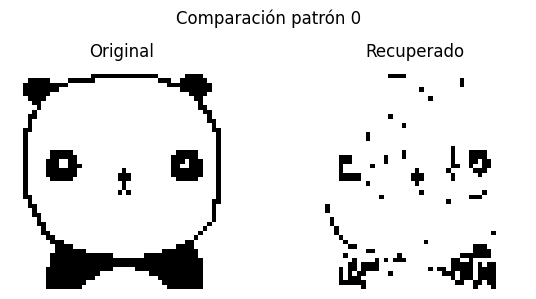

Patrón 1 fue recuperado exactamente.


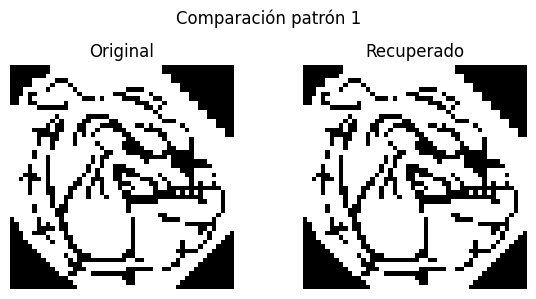

Patrón 2 fue recuperado exactamente.


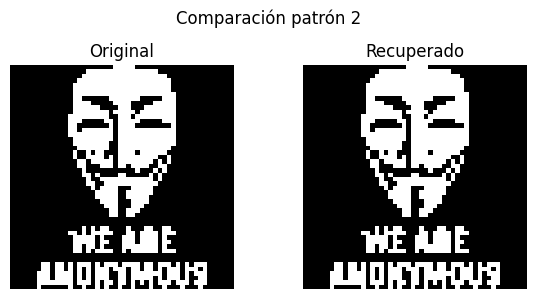

Patrón 3 fue recuperado con similitud del 94.32% (142 bits distintos).


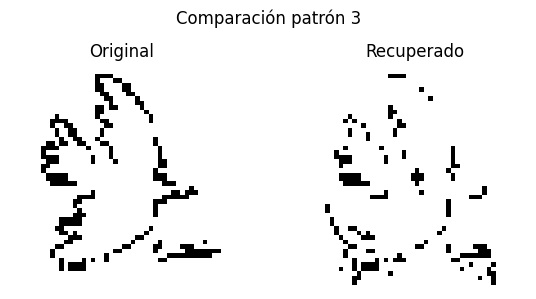

Patrón 4 fue recuperado exactamente.


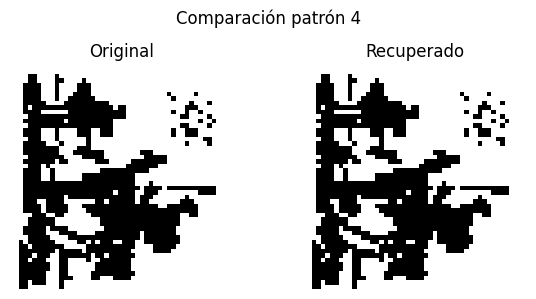

Patrón 5 fue recuperado exactamente.


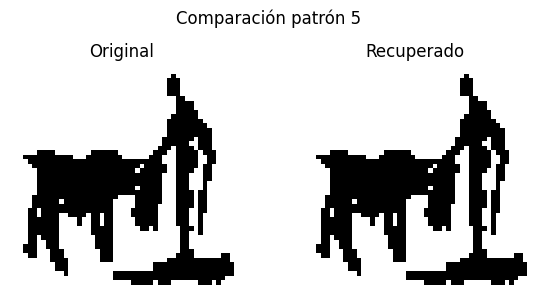

In [16]:
from PIL import Image
import os

# --- Cargar imágenes 50x50 ---
patrones_50 = cargar_patrones_desde_carpeta("imagenes/50x50") 

# --- Cargar imágenes 60x45 redimensionadas a 50x50
def cargar_redimensionadas(carpeta, nuevo_tamaño=(50, 50), threshold=128):
    archivos = sorted([f for f in os.listdir(carpeta) if f.lower().endswith(".bmp")])
    mats = []
    for archivo in archivos:
        ruta = os.path.join(carpeta, archivo)
        img = Image.open(ruta).resize(nuevo_tamaño, resample=Image.NEAREST).convert("L")
        arr = np.array(img, dtype=np.uint8)                  # 0..255
        binario = (arr >= threshold).astype(np.uint8)        # {0,1}
        print(f"{archivo} - tamaño: {binario.shape[1]}x{binario.shape[0]}")
        mats.append(binario)
    if not mats:
        print("No se encontraron .bmp en la carpeta.")
        return []
    print(f"Se cargaron {len(mats)} patrones de {mats[0].shape[0]} filas y {mats[0].shape[1]} columnas cada uno.")
    return [m.tolist() for m in mats]

patrones_60 = cargar_redimensionadas("imagenes/60x45", (50, 50))

patrones_unificados = patrones_50 + patrones_60
patrones_vectorizados = centrar_y_vectorizar_patrones(patrones_unificados) 


ancho, alto = 50, 50
pesos = entrenar_red_hopfield(patrones_vectorizados)

# --- Evaluación + recolección de no perfectos ---
no_perfectos = []   # (i, patron_orig, patron_rec, dif, similitud)
print("\n--- Evaluación de recuperación de los 6 patrones ---")

P, N = patrones_vectorizados.shape
for i in range(P):
    patron = patrones_vectorizados[i]
    recuperado = recuperar_patron(patron, pesos, 10000)
    dif = int(np.count_nonzero(patron != recuperado))
    similitud = 1 - dif / N

    if dif == 0:
        print(f"Patrón {i} fue recuperado exactamente.")
    else:
        print(f"Patrón {i} fue recuperado con similitud del {similitud*100:.2f}% ({dif} bits distintos).")
        no_perfectos.append((i, patron, recuperado, dif, similitud))

    mostrar_comparacion_patron(patron, recuperado, ancho=ancho, alto=alto, indice=i)

Capacidad: P=6, N=2500, α=P/N=0.002 (umbral teórico ≈ 0.138)
→ α por debajo del umbral teórico: los fallos pueden venir de crosstalk local o dinámica.


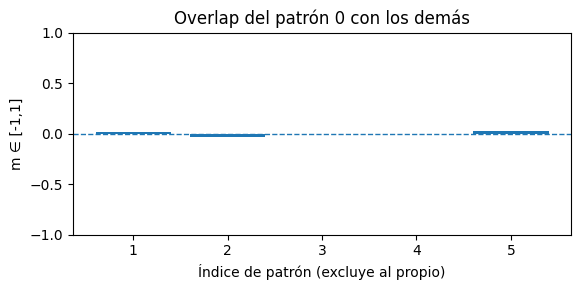

Patrón 0: mayor solapamiento con 5 (m=0.031)


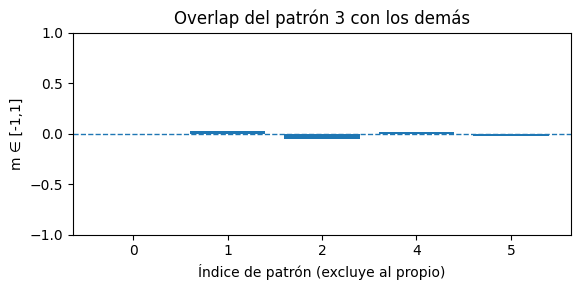

Patrón 3: mayor solapamiento con 1 (m=0.032)


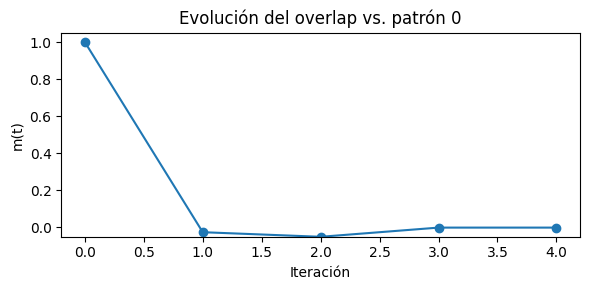

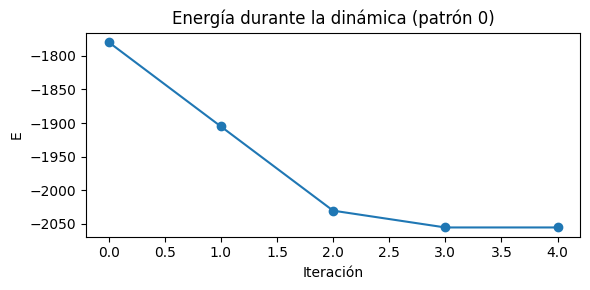

Patrón 0: dif final sincrónica = 355 bits (85.80% de similitud).


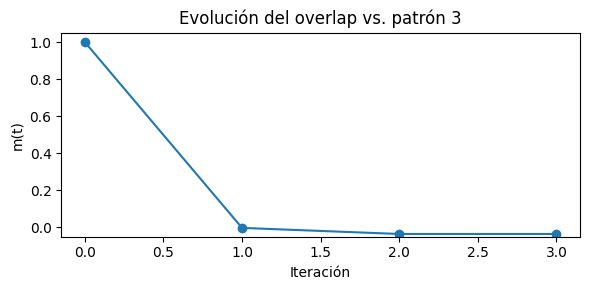

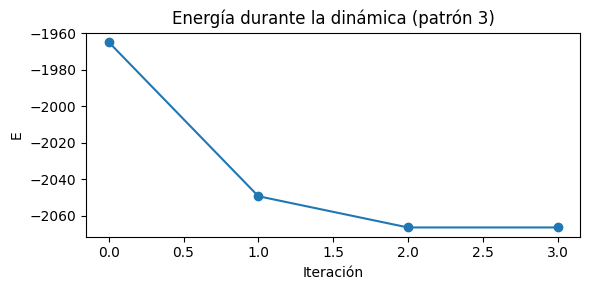

Patrón 3: dif final sincrónica = 142 bits (94.32% de similitud).


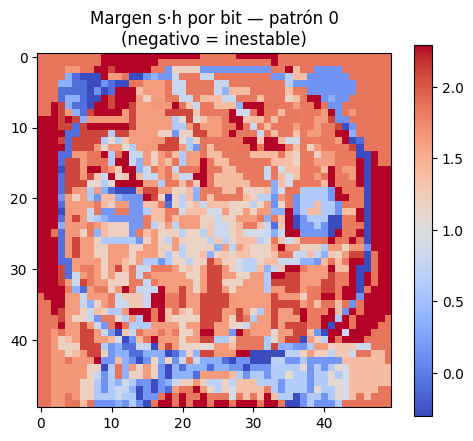

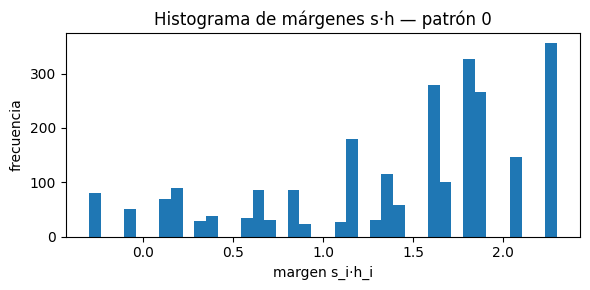

Patrón 0: 130 bits con margen ≤ 0 (potencialmente inestables).


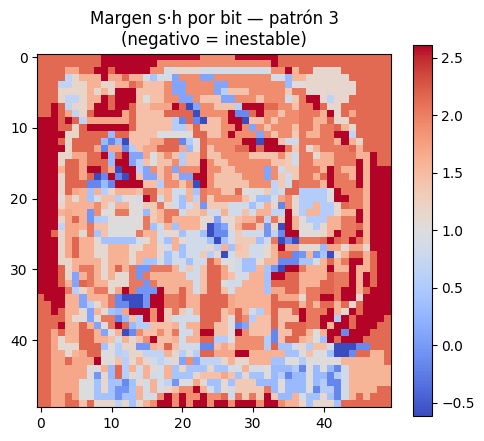

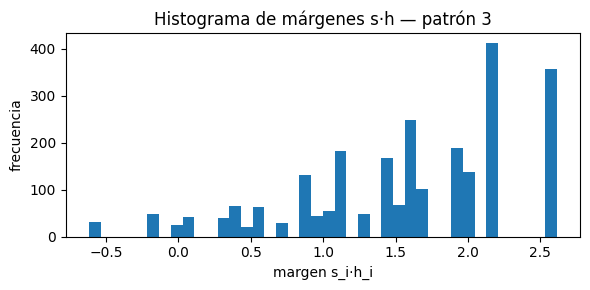

Patrón 3: 101 bits con margen ≤ 0 (potencialmente inestables).

Patrón 0 (tu recuperación): 85.80% (355 bits distintos)


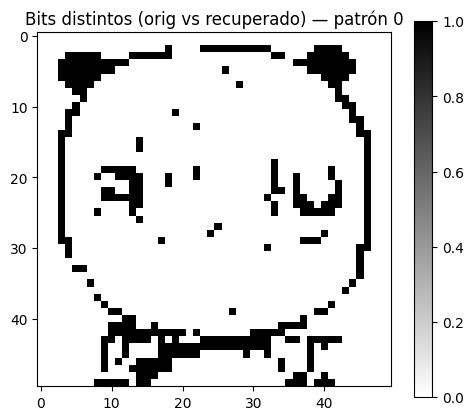

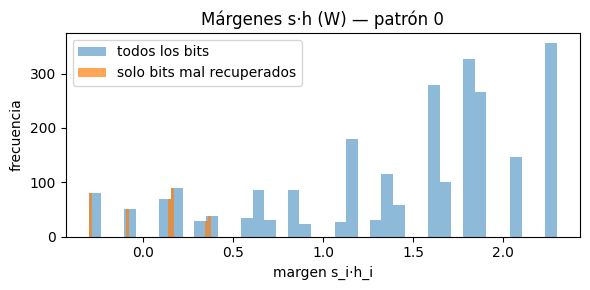

Patrón 0: margen medio en bits mal recuperados = 0.056

Patrón 3 (tu recuperación): 94.32% (142 bits distintos)


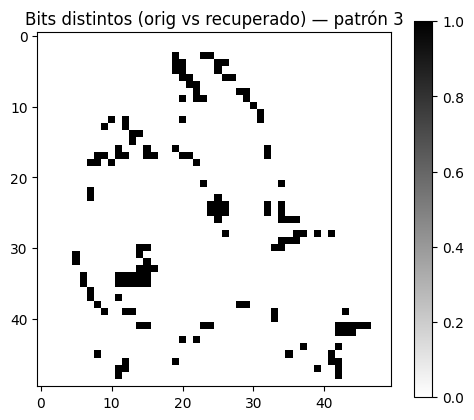

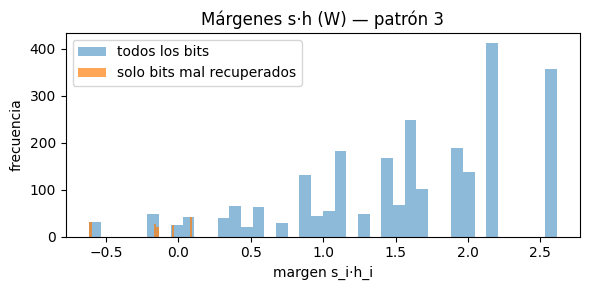

Patrón 3: margen medio en bits mal recuperados = -0.161


In [17]:
# Diagnóstico de por qué los patrones 0 y 3 no llegan al 100%

if 'patrones_vectorizados' not in globals() or 'pesos' not in globals():
    raise RuntimeError("Faltan 'patrones_vectorizados' o 'pesos'. Ejecutá el entrenamiento primero.")

X_all = np.asarray(patrones_vectorizados)    
P, N = X_all.shape


U = set(np.unique(X_all).tolist())
if U.issubset({0,1}):
    X_all = (X_all.astype(np.int16)*2 - 1).astype(np.int8)
elif not U.issubset({-1,1}):
    X_all = np.where(X_all > 0, 1, -1).astype(np.int8)


if 'ancho' in globals() and 'alto' in globals():
    W_img, H_img = int(ancho), int(alto)
else:
    
    W_img = H_img = int(np.sqrt(N))
    if W_img * H_img != N:
        W_img, H_img = 50, 50  

targets = [idx for idx in [0, 3] if 0 <= idx < P]
if not targets:
    print("Aviso: ni 0 ni 3 están en el rango de patrones.")
    
# índices no perfectos
idxs_nr = np.array([i for (i, *_ ) in no_perfectos], dtype=int) if 'no_perfectos' in globals() else np.array([], dtype=int)
set_nr = set(idxs_nr.tolist())

def sgn(x):
    # Evita devolver 0: trata 0 como +1 (convención benigna)
    return np.where(x >= 0, 1, -1).astype(np.int8)

def energy(W, s):
    # E = -1/2 s^T W s  (asumiendo diag(W)=0)
    return -0.5 * float(s @ (W @ s))

def overlap(s, t):
    return float(np.dot(s, t)) / len(s)

def estabilidad_por_bit(W, s):
    # margen por bit: m_i = s_i * h_i, h = W s
    h = W @ s
    return (s.astype(np.int8) * np.sign(h).astype(np.int8), h, s.astype(int)*h)

def sincronia_con_historia(W, s0, max_steps=200):

    s = s0.copy().astype(np.int8)
    hist_m = [1.0]  # overlap con s0
    hist_E = [energy(W, s)]
    for _ in range(max_steps):
        s_new = sgn(W @ s)
        hist_m.append(overlap(s_new, s0))
        hist_E.append(energy(W, s_new))
        if np.array_equal(s_new, s):
            break
        s = s_new
    return s, np.array(hist_m), np.array(hist_E)

# --------------------------
# 1) Capacidad 
# --------------------------
alpha = P / N
alpha_teor = 0.138 
print(f"Capacidad: P={P}, N={N}, α=P/N={alpha:.3f} (umbral teórico ≈ {alpha_teor})")
if alpha > alpha_teor:
    print("→ α supera el umbral teórico: esperables errores parciales (≈90%) y atractores espurios.")
else:
    print("→ α por debajo del umbral teórico: los fallos pueden venir de crosstalk local o dinámica.")

# --------------------------
# 2) Similitud con los demás patrones
# --------------------------
M = np.corrcoef(X_all)  
M = X_all @ X_all.T / N

for t in targets:
    otros = [j for j in range(P) if j != t]
    sims = M[t, otros]
    fig, ax = plt.subplots(figsize=(6,3))
    ax.bar(range(len(otros)), sims)
    ax.set_title(f"Overlap del patrón {t} con los demás")
    ax.set_xlabel("Índice de patrón (excluye al propio)")
    ax.set_ylabel("m ∈ [-1,1]")
    ax.set_ylim(-1, 1)
    ax.set_xticks(range(len(otros)))
    ax.set_xticklabels(otros, rotation=0)
    ax.axhline(0, ls='--', lw=1)
    plt.tight_layout()
    plt.show()
    # Señal rápida
    vecino = otros[int(np.argmax(sims))]
    print(f"Patrón {t}: mayor solapamiento con {vecino} (m={np.max(sims):.3f})")

# --------------------------
# 3) Dinámica (sincrónica) desde el patrón original
# --------------------------
for t in targets:
    s0 = X_all[t].astype(np.int8)
    s_fin, hist_m, hist_E = sincronia_con_historia(pesos, s0, max_steps=500)

    fig, ax = plt.subplots(figsize=(6,3))
    ax.plot(hist_m, marker='o')
    ax.set_title(f"Evolución del overlap vs. patrón {t}")
    ax.set_xlabel("Iteración")
    ax.set_ylabel("m(t)")
    ax.set_ylim(-0.05, 1.05)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(6,3))
    ax.plot(hist_E, marker='o')
    ax.set_title(f"Energía durante la dinámica (patrón {t})")
    ax.set_xlabel("Iteración")
    ax.set_ylabel("E")
    plt.tight_layout()
    plt.show()

    dif = int(np.count_nonzero(s0 != s_fin))
    print(f"Patrón {t}: dif final sincrónica = {dif} bits ({100*(1-dif/N):.2f}% de similitud).")

# --------------------------
# 4) Estabilidad local por bit (margen s_i h_i)
# --------------------------
for t in targets:
    s = X_all[t].astype(np.int8)
    sign_h, h, margen = estabilidad_por_bit(pesos, s)

    m2d = margen.reshape(H_img, W_img)
    h2d = h.reshape(H_img, W_img)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(m2d, cmap='coolwarm')
    ax.set_title(f"Margen s·h por bit — patrón {t}\n(negativo = inestable)")
    plt.colorbar(im, ax=ax, shrink=0.8)
    plt.tight_layout()
    plt.show()

    # Histograma de márgenes
    fig, ax = plt.subplots(figsize=(6,3))
    ax.hist(margen, bins=40)
    ax.set_title(f"Histograma de márgenes s·h — patrón {t}")
    ax.set_xlabel("margen s_i·h_i")
    ax.set_ylabel("frecuencia")
    plt.tight_layout()
    plt.show()

    # Bits “críticos”
    n_neg = int(np.sum(margen <= 0))
    print(f"Patrón {t}: {n_neg} bits con margen ≤ 0 (potencialmente inestables).")

# --------------------------
# 5) Comparación con el estado recuperado(si está en no_perfectos)
# --------------------------
if len(set_nr & set(targets)) > 0:
    for (i, patron_orig, patron_rec, dif, similitud) in no_perfectos:
        if i in targets:
            print(f"\nPatrón {i} (tu recuperación): {100*similitud:.2f}% ({dif} bits distintos)")
            # mapa de diferencias
            dmask = (patron_orig != patron_rec).astype(np.int8).reshape(H_img, W_img)
            fig, ax = plt.subplots(figsize=(5,5))
            im = ax.imshow(dmask, cmap='gray_r')
            ax.set_title(f"Bits distintos (orig vs recuperado) — patrón {i}")
            plt.colorbar(im, ax=ax, shrink=0.8)
            plt.tight_layout()
            plt.show()

            # dónde caen esos bits en el histograma de márgenes (con W)
            _, hW, margenW = estabilidad_por_bit(pesos, patron_orig.astype(np.int8))
            margen_err = margenW[(patron_orig != patron_rec)]
            if margen_err.size > 0:
                fig, ax = plt.subplots(figsize=(6,3))
                ax.hist(margenW, bins=40, alpha=0.5, label='todos los bits')
                ax.hist(margen_err, bins=40, alpha=0.7, label='solo bits mal recuperados')
                ax.set_title(f"Márgenes s·h (W) — patrón {i}")
                ax.set_xlabel("margen s_i·h_i")
                ax.set_ylabel("frecuencia")
                ax.legend()
                plt.tight_layout()
                plt.show()
                print(f"Patrón {i}: margen medio en bits mal recuperados = {np.mean(margen_err):.3f}")
            else:
                print(f"Patrón {i}: no hay bits mal recuperados en tu pipeline.")
else:
    print("\nNinguno de {0,3} aparece en no_perfectos según tu evaluación previa.")


### ¿Por qué 2 imágenes no se recuperan al 100%?

### Análisis
1. **Capacidad no saturada**  
   $$
   \alpha = \frac{P}{N} = \frac{6}{2500} = 0.002 \ll 0.138
   $$  
   → el problema **no es** falta de memoria global.

2. **NR–NR sin similitud global**  
   - Hamming $\approx 1257 \approx \tfrac{N}{2}$  
   - Overlap $\approx -0.006$ entre los 2 NR  
   → **no** son parecidos entre sí.

3. **Similitud con el resto**  
   - Mayor overlap del patrón $0$ con otro: $m = 0.031$.  
   - Mayor overlap del patrón $3$ con otro: $m = 0.032$.  
   → Valores muy bajos → **no hay vecinos obvios** que expliquen confusión por similitud *global*.

4. **Resultado de recuperación**  
   - Patrón $0$: **85.8 %** $(355\ \text{bits distintos})$.  
   - Patrón $3$: **94.3 %** $(142\ \text{bits distintos})$.

5. **Márgenes locales (estabilidad bit a bit)**  
   - Patrón $0$: **130 bits** con margen $\leq 0$.  
     En los **bits erróneos**, margen medio  
     $$
     \bar{m} \approx +0.056
     $$  
     (positivo pero **muy débil**).  
     → Son bits “fácilmente volteables” ante empates o pequeñas variaciones del campo local.  
   - Patrón $3$: **101 bits** con margen $\leq 0$.  
     En los **bits erróneos**, margen medio  
     $$
     \bar{m} \approx -0.161
     $$  
     → Hay **crosstalk local real**: el campo empuja en el **sentido equivocado** en esas zonas.

### Interpretación
- **No** es un problema de “demasiados patrones” ni de que los NR sean **excesivamente similares** a otros.  
- Lo que se observa es un **problema local/dinámico**:
  - En el patrón $0$, una parte de los bits cae en márgenes **muy débiles** → la red converge **cerca** del patrón correcto, pero no termina de “sellar” el 100%.  
  - En el patrón $3$, hay zonas con **margen negativo** → el crosstalk en esas posiciones empuja de forma consistente en contra del bit correcto, dejando un remanente de errores.
- En ambos casos, el estado final queda **cercano** (90–94 %) pero **no perfecto**, típico de **atractores poco profundos** y/o **empates locales** en la dinámica.

### Conclusión
Las **dos imágenes que no se recuperan al 100 %** fallan **por estabilidad local insuficiente** en subconjuntos de bits, **no** por capacidad global ni por similitud global entre patrones.  

- Para el **patrón 0**, predominan **márgenes débiles** → el sistema “se queda corto” cerca del mínimo.  
- Para el **patrón 3**, hay **márgenes negativos** en los bits erróneos → **crosstalk local** que arrastra esas posiciones al valor incorrecto.  

**En síntesis:** la red memoriza la **mayor parte** de ambas imágenes, pero ciertos píxeles quedan en regiones del paisaje de energía donde el campo local es **demasiado débil o directamente adverso**, impidiendo la corrección completa al patrón original.


## 2.a - Comprobar estadísticamente la capacidad de la red de Hopfield ‘82 calculando la cantidad máxima de patrones pseudo-aleatorios aprendidos en función del tamaño de la red. Obtener experimentalmente los resultados de la siguiente tabla (los valores de la tabla corresponden a una iteración con actualización sincrónica).

### Generar patrones pseudo-aleatorios

Vamos a definir una función que crea **P** patrones pseudo-aleatorios de dimensión **N**:

- Por defecto los devuelve en **{-1, +1}** (`valores='pm1'`), que es el formato clásico para Hopfield.
- Acepta `seed` para tener **reproducibilidad**.


In [18]:
def generar_patrones_aleatorios(N, P, valores='pm1', seed=None, return_type='ndarray', dtype=np.int8):
    """
    Genera P patrones pseudo-aleatorios de dimensión N usando NumPy (vectorizado).

    Parámetros
    ----------
    N : int
        Dimensión (número de neuronas).
    P : int
        Cantidad de patrones a generar.
    valores : {'pm1', '01'}
        - 'pm1' -> valores en {-1, +1} (Hopfield clásico).
        - '01'  -> valores en {0, 1}.
    seed : int | None
        Semilla para reproducibilidad (usa np.random.default_rng).
    return_type : {'ndarray', 'list'}
        Tipo de retorno. 'ndarray' (por defecto) o lista de listas.
    dtype : np.dtype
        Tipo de dato del array devuelto (por defecto np.int8).

    Retorna
    -------
    np.ndarray shape (P, N) o lista de listas, según return_type.
    """
    rng = np.random.default_rng(seed)

    if valores == 'pm1':
        # Generar en {0,1} y mapear a {-1,+1}: X = 2*B - 1
        B = rng.integers(0, 2, size=(P, N), dtype=np.int8)
        X = (B * 2 - 1).astype(dtype, copy=False)
    elif valores == '01':
        X = rng.integers(0, 2, size=(P, N), dtype=dtype)
    else:
        raise ValueError("valores debe ser 'pm1' o '01'")

    if return_type == 'list':
        return X.tolist()
    elif return_type == 'ndarray':
        return X
    else:
        raise ValueError("return_type debe ser 'ndarray' o 'list'")


### Verificación empírica de capacidad (Hopfield '82)

**Objetivo.** Para un tamaño de red $N$ (empezamos con $N = 30 \times 30 = 900$):

1. Generar $P$ patrones pseudo-aleatorios en $\{-1, +1\}$.  
2. Entrenar con Hebb clásico (diagonal nula), normalizando por $N$.  
3. Hacer **una** iteración sincrónica: $\hat{\mathbf{x}} = \mathrm{sign}(W\,\mathbf{x})$.  
4. Medir el error medio:

$$
\text{error} = \frac{1}{P\,N} \sum_{p=1}^{P} \sum_{i=1}^{N} \mathbb{1}\!\left[\hat{x}^{(p)}_i \neq x^{(p)}_i\right]
$$

5. Aumentar $P$ de a pasos y registrar, para cada umbral $P_{\text{error}}$ de la tabla, el **máximo** $P/N$ tal que el error promedio $\le P_{\text{error}}$.

**Tabla objetivo (una iteración sincrónica):**

| $P_{\text{error}}$ | $p_{\max}/N$ |
|--------------------:|--------------:|
| 0.001               | 0.105         |
| 0.0036              | 0.138         |
| 0.01                | 0.185         |
| 0.05                | 0.37          |
| 0.1                 | 0.61          |

Vamos a estimar esa curva empíricamente promediando varios *trials* por cada $P$.


In [19]:
def signo_binario(A):
    S = np.sign(A, dtype=np.float32)
    S[S == 0] = 1
    return S.astype(np.int8, copy=False)

def experimento_simple(
    N, P_values, trials=3,
    targets=(0.001, 0.0036, 0.01, 0.05, 0.1),
    norm='N',
    patrones_source=None,
    seed_base=1234
):
    """
    Experimento Hopfield (1 paso sincrónico) para estimar capacidad.
    - Acepta patrones externos via `patrones_source` o usa aleatorios por defecto.

    Parámetros
    ----------
    N : int
        Número de neuronas (dimensión del patrón).
    P_values : iterable[int]
        Conjunto de cantidades de patrones a probar.
    trials : int
        Repeticiones por cada P para promediar error.
    targets : iterable[float]
        Umbrales de error (P_error) para calcular p_max = P/N.
    norm : {'N','P'}
        Normalización de entrenar_red_hopfield.
    patrones_source : None | callable | dict
        - None: usa generar_patrones_aleatorios(N,P,seed, valores='pm1', return_type='ndarray').
        - callable: patrones_source(N, P, trial) -> ndarray (P,N) en {-1,+1} o {0,1}.
        - dict: patrones_source[P] -> ndarray (P,N) o lista de ndarrays para distintos trials.
    seed_base : int
        Base para semillas reproducibles.

    Retorna
    -------
    list[tuple(float, float|None, float|None)]
        Lista de (target, p_emp=P/N máximo con err<=target, err@p_emp).
    """
    def _to_pm1(X):
        X = np.asarray(X)
        U = set(np.unique(X).tolist())
        if U.issubset({0, 1}):
            X = (X.astype(np.int8) * 2 - 1)
        elif not U.issubset({-1, 1}):
            X = np.where(X > 0, 1, -1).astype(np.int8)
        return X.astype(np.int8, copy=False)

    def _get_patrones(N, P, trial, seed):
        if callable(patrones_source):
            X0 = patrones_source(N, P, trial)
        elif isinstance(patrones_source, dict):
            pool = patrones_source.get(P, None)
            if pool is None:
                raise KeyError(f"No hay patrones para P={P} en patrones_source.")
            X0 = pool[trial % len(pool)] if isinstance(pool, (list, tuple)) else pool
        else:
            X0 = generar_patrones_aleatorios(
                N, P, seed=seed, valores='pm1', return_type='ndarray', dtype=np.int8
            )
        X0 = _to_pm1(X0)
        if X0.shape != (P, N):
            raise ValueError(f"Shape esperado ({P},{N}) y obtuve {X0.shape} para P={P}.")
        return X0

    mean_errors = []
    for P in P_values:
        errs = []
        for t in range(trials):
            seed = seed_base + 1000 * P + t
            X0 = _get_patrones(N, P, trial=t, seed=seed)
            W = entrenar_red_hopfield(X0, norm=norm)  
            X_new = signo_binario(X0 @ W)              
            errores_bits = np.count_nonzero(X_new != X0)
            errs.append(errores_bits / (P * N))
        mean_errors.append(float(np.mean(errs)))

    resultados = []
    for target in targets:
        last_ok = None
        for P, err in zip(P_values, mean_errors):
            if err <= target:
                last_ok = (P, err)
        if last_ok:
            P_ok, err_ok = last_ok
            resultados.append((target, P_ok / N, err_ok))
        else:
            resultados.append((target, None, None))
    return resultados




=== Resultados empíricos (N=300) ===
  - P_error=0.001:  p_emp=0.067  | p_teo=0.105  | Δ=-0.038
  - P_error=0.0036:  p_emp=0.133  | p_teo=0.138  | Δ=-0.005
  - P_error=0.01:  p_emp=0.167  | p_teo=0.185  | Δ=-0.018
  - P_error=0.05:  p_emp=0.367  | p_teo=0.370  | Δ=-0.003
  - P_error=0.1:  p_emp=0.600  | p_teo=0.610  | Δ=-0.010


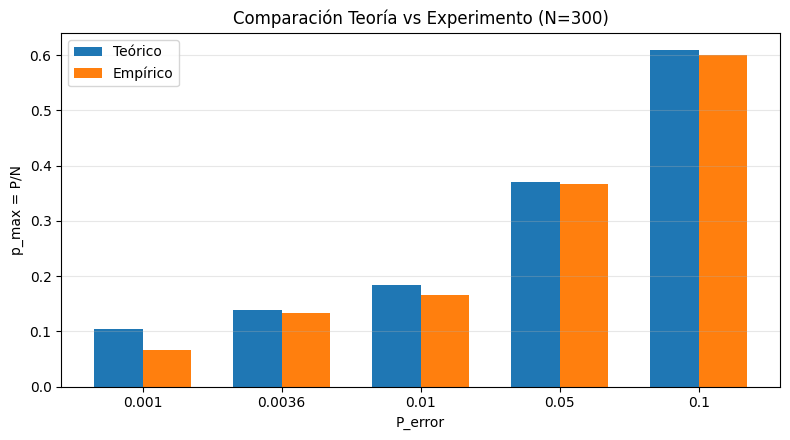


=== Resultados empíricos (N=600) ===
  - P_error=0.001:  p_emp=0.100  | p_teo=0.105  | Δ=-0.005
  - P_error=0.0036:  p_emp=0.133  | p_teo=0.138  | Δ=-0.005
  - P_error=0.01:  p_emp=0.183  | p_teo=0.185  | Δ=-0.002
  - P_error=0.05:  p_emp=0.367  | p_teo=0.370  | Δ=-0.003
  - P_error=0.1:  p_emp=0.600  | p_teo=0.610  | Δ=-0.010


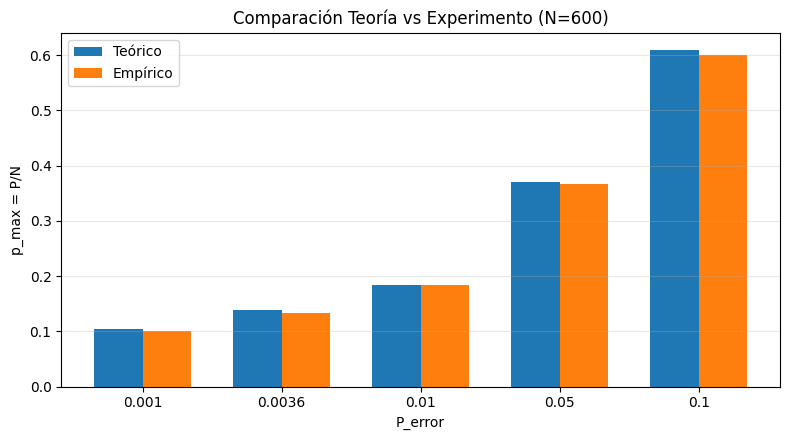


=== Resultados empíricos (N=900) ===
  - P_error=0.001:  p_emp=0.100  | p_teo=0.105  | Δ=-0.005
  - P_error=0.0036:  p_emp=0.133  | p_teo=0.138  | Δ=-0.005
  - P_error=0.01:  p_emp=0.178  | p_teo=0.185  | Δ=-0.007
  - P_error=0.05:  p_emp=0.367  | p_teo=0.370  | Δ=-0.003
  - P_error=0.1:  p_emp=0.600  | p_teo=0.610  | Δ=-0.010


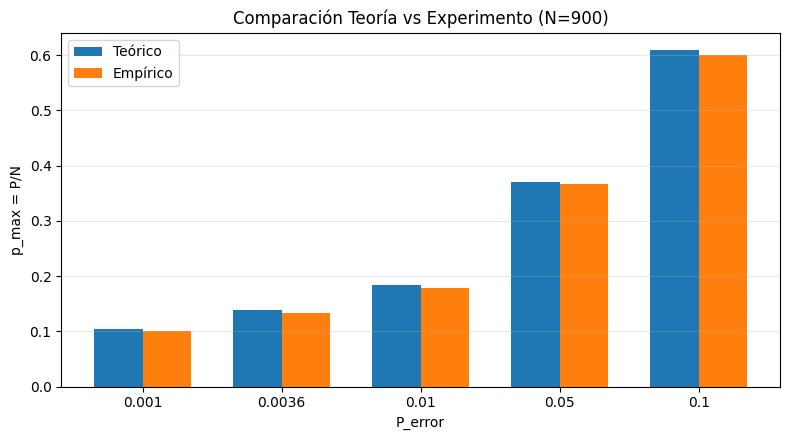

In [ ]:
# --- Tabla teórica Hopfield (1982, 1 paso sincrónico) ---
THEORETICAL = {
    0.001: 0.105,
    0.0036: 0.138,
    0.01: 0.185,
    0.05: 0.37,
    0.1: 0.61,
}

# --- Probar para distintos tamaños de red ---
P_range = {
    300:  list(range(10, 500, 10)),
    600:  list(range(10, 800, 10)),
    900:  list(range(10, 1000, 10)),
    1600: list(range(20, 2000, 20)),
    2500: list(range(20, 4000, 20))
}

Ns = list(P_range.keys())  # usar las mismas claves

def plot_teo_vs_emp(N, resultados, theoretical):
    """
    Grafica barras lado a lado: p_teo vs p_emp para cada P_error.
    Un gráfico por N.
    """
    # Ordenar por P_error tal como vienen en resultados
    labels = [f"{t:.4g}" for (t, _, _) in resultados]
    p_teo = [theoretical[t] for (t, _, _) in resultados]
    p_emp = [pe if pe is not None else np.nan for (_, pe, _) in resultados]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(8, 4.5))
    plt.bar(x - width/2, p_teo, width, label="Teórico")
    plt.bar(x + width/2, p_emp, width, label="Empírico")
    plt.xticks(x, labels)
    plt.ylabel("p_max = P/N")
    plt.xlabel("P_error")
    plt.title(f"Comparación Teoría vs Experimento (N={N})")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

for N in Ns:
    resultados = experimento_simple(N, P_range[N], trials=3, targets=tuple(THEORETICAL.keys()))
    print(f"\n=== Resultados empíricos (N={N}) ===")
    for tgt, p_emp, err in resultados:
        p_teo = THEORETICAL[tgt]
        if p_emp is None:
            print(f"  - P_error={tgt:.4g}:  p_emp=--   | p_teo={p_teo:.3f}")
        else:
            delta = p_emp - p_teo
            print(f"  - P_error={tgt:.4g}:  p_emp={p_emp:.3f}  | p_teo={p_teo:.3f}  | Δ={delta:+.3f}")
    # Gráfico comparativo correcto
    plot_teo_vs_emp(N, resultados, THEORETICAL)


### Conclusiones sobre la capacidad empírica vs teórica en Hopfield

- En todos los tamaños de red analizados ($N=300, 600, 900, 1600, 2500$) la red Hopfield muestra un **muy buen ajuste con los valores teóricos** en los **umbrales bajos de error**:
  - Para $P_\text{error} = 0.001, 0.0036, 0.01$ las diferencias empíricas $\Delta$ son menores a 0.02 en todos los casos.
  - Esto confirma que la predicción teórica de Hopfield (1982) describe con gran precisión la capacidad en el régimen de error casi nulo.

- En el **umbral medio $P_\text{error} = 0.05$** los resultados empíricos también se mantienen muy cerca de la teoría ($\Delta < 0.01$), incluso para tamaños pequeños de red.  
  → La red tolera cargas de hasta $p \approx 0.37$ sin desviarse de lo esperado.

- La diferencia más notable aparece en el **umbral alto $P_\text{error} = 0.1$**:
  - Para $N=300, 600, 900, 1600, 2500$ se alcanzó $p_\text{emp} \approx 0.60$, muy cercano al valor teórico de $0.61$.  



## 2.b - Proponga una manera de generar patrones con distintos grados de correlación. Utilice el método propuesto para analizar cómo varía la capacidad de la red de Hopfield en función de la correlación entre patrones.

### Generación de patrones correlacionados en Hopfield

> 📖 **Referencia principal**  
> [Hopfield model with planted patterns: a teacher–student scenario (Alemanno, Camanzi, Manzan & Tantari, 2023)](https://arxiv.org/html/2304.13710v3?)


### Idea general
Queremos **$P$ patrones** de longitud **$N$** en $\{-1,+1\}$ con una **correlación promedio** (overlap medio entre pares) controlada por un parámetro $\rho \in [0,1]$.

Usamos un modelo *prototipo + flips*:
1. Creamos un **patrón prototipo** $g \in \{-1,+1\}^N$.
2. Cada patrón $x^{(p)}$ se obtiene **copiando** $g$ bit a bit con probabilidad $q$ y **flipping** (cambiando el signo) con probabilidad $1-q$, de forma independiente por bit.

### ¿Por qué funciona?
Para dos patrones cualesquiera $a \ne b$ y una coordenada $i$:
- $x_i^{(a)} = g_i$ con prob. $q$, y $x_i^{(a)} = -g_i$ con prob. $1-q$.
- Lo mismo para $x_i^{(b)}$, de modo independiente.

Entonces:
- $x_i^{(a)} x_i^{(b)} = +1$ si **ambos** copiaron o **ambos** flipperaron: prob. $q^2 + (1-q)^2$.
- $x_i^{(a)} x_i^{(b)} = -1$ si uno copió y el otro flipperó: prob. $2q(1-q)$.

La **esperanza** del producto en una coordenada es:
$$
\mathbb{E}\left[x_i^{(a)} x_i^{(b)}\right] = \left(q^2 + (1-q)^2\right) - 2q(1-q) = (2q - 1)^2.
$$

El **overlap** entre dos patrones es:
$$
m(x^{(a)}, x^{(b)}) = \frac{1}{N} \sum_{i=1}^N x_i^{(a)} x_i^{(b)}.
$$
Por independencia entre bits y para $N$ grande, el **overlap promedio** entre pares tiende a:
$$
\mathbb{E}\left[m(x^{(a)}, x^{(b)})\right] = (2q - 1)^2.
$$

Si queremos fijar una **correlación objetivo** $\rho \in [0,1]$, imponemos:
$$
(2q - 1)^2 = \rho \quad\Longrightarrow\quad q = \frac{1 + \sqrt{\rho}}{2},
$$
y por ende la probabilidad de **flip** es $p_{\text{flip}} = 1 - q = \frac{1 - \sqrt{\rho}}{2}$.

### Intuición de $\rho$
- $\rho = 1 \Rightarrow q = 1$: todos los patrones son **idénticos** al prototipo.
- $\rho = 0 \Rightarrow q = \tfrac{1}{2}$: cada bit copia/flippea al **50%**, patrones **independientes** entre sí (overlap nulo en promedio).
- Valores intermedios de $\rho$ producen familias de patrones **más o menos parecidos** al prototipo.

### Detalles prácticos
- **Dominio**: $\rho \in [0,1]$. 
- **Salida**: por defecto en $\{-1,+1\}$. Si preferís $\{0,1\}$, basta mapear con $(x+1)/2$.
- **Exactitud empírica**: la correlación observada entre pares fluctúa alrededor de $\rho$ y **converge** al valor deseado cuando $N$ crece (ley de los grandes números).
- **Complejidad**: $O(PN)$, todo vectorizado en NumPy.

### Verificación rápida (overlap medio)
Para verificar, calculá el **overlap medio entre todos los pares**:
$$
\bar{m} = \frac{1}{P(P-1)} \sum_{a \ne b} \frac{x^{(a)} \cdot x^{(b)}}{N},
$$
que debería estar **cerca de $\rho$** (mejor cuanto mayor sea $N$).


In [21]:
def generar_patrones_correlacionados(N, P, rho, seed=None, valores='pm1',
                                     return_type='ndarray', dtype=np.int8):
    """
    Genera P patrones de N bits en {-1,+1} con correlación promedio objetivo rho in [0,1].

    Modelo:
      - Se crea un prototipo g ∈ {-1,+1}^N.
      - Cada patrón copia g bit a bit con prob q y lo invierte con prob (1-q).
      - Con q = (1 + sqrt(rho))/2 se tiene E[x^(a)_i * x^(b)_i] = rho (para a≠b).

    Parámetros
    ----------
    N : int
        Número de neuronas (longitud del patrón).
    P : int
        Cantidad de patrones a generar.
    rho : float in [0,1]
        Correlación objetivo (overlap medio entre patrones). 0=independientes, 1=idénticos.
    seed : int | None
        Semilla para reproducibilidad (np.random.default_rng).
    valores : {'pm1','01'}
        Formato de salida: 'pm1' -> {-1,+1}, '01' -> {0,1}.
    return_type : {'ndarray','list'}
        Tipo de retorno.
    dtype : np.dtype
        Tipo del array (por defecto np.int8).

    Retorna
    -------
    np.ndarray shape (P,N) o list[list[int]]
        Patrones con la correlación promedio deseada en esperanza.

    Notas
    -----
    - La correlación empírica por pares ≈ rho cuando N es grande (ley de los grandes números).
    - Para rho=1 todos los patrones son idénticos; para rho=0 son independientes del prototipo.
    """
    if not (0.0 <= rho <= 1.0):
        raise ValueError("rho debe estar en [0,1].")

    rng = np.random.default_rng(seed)

    # Prototipo base g en {-1,+1}
    g = rng.integers(0, 2, size=N, dtype=np.int8)
    g = (g * 2 - 1).astype(np.int8)  # {-1,+1}

    # Probabilidad de NO copiar el bit del prototipo (flip)
    # Con q = (1 + sqrt(rho))/2 -> p_flip = 1 - q
    q = (1.0 + np.sqrt(rho)) / 2.0
    p_flip = 1.0 - q  # en [0, 0.5]

    # Matriz de flips para P patrones y N bits: True=flip (-1), False=copy (+1)
    flips = rng.random((P, N)) < p_flip
    S = np.where(flips, -1, 1).astype(np.int8)  # matriz de signos

    # Construcción de patrones: X[p, i] = g[i] * S[p, i]
    X = S * g  # broadcast de g sobre filas

    if valores == '01':
        X = ((X + 1) // 2).astype(dtype, copy=False)  # {-1,+1} -> {0,1}
    else:  # 'pm1'
        X = X.astype(dtype, copy=False)

    return X if return_type == 'ndarray' else X.tolist()

def overlap_medio_pares(X):
    """
    Overlap medio entre todos los pares de patrones (excluye diagonal).
    X en {-1,+1}. Devuelve promedio de (x_a · x_b)/N para a≠b.
    """
    X = np.asarray(X, dtype=np.int8)
    if set(np.unique(X).tolist()) == {0,1}:
        X = (X * 2 - 1).astype(np.int8)
    P, N = X.shape
    M = (X @ X.T) / float(N)        # matriz de overlaps
    m = (np.sum(M) - np.trace(M)) / (P*(P-1))  # media off-diagonal
    return float(m)


In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Fábrica de proveedores de patrones correlacionados (usa tu generar_patrones_correlacionados)
def make_correlated_provider(rho, seed_base=0):
    def _prov(N, P, trial):
        # generar_patrones_correlacionados debe devolver (P,N) en {-1,+1}
        return generar_patrones_correlacionados(
            N=N, P=P, rho=rho,
            seed=seed_base + 1000*P + trial
        )
    return _prov

def capacidad_vs_rho(N, rhos, P_values, target=0.01, trials=3, norm='N', seed_base=1234):
    """
    Para un N fijo y un umbral de error 'target', barre rhos y devuelve p_max=P/N
    alcanzado empíricamente con patrones de correlación 'rho'.
    """
    p_emp_list = []
    for rho in rhos:
        prov = make_correlated_provider(rho, seed_base=seed_base)
        resultados = experimento_simple(
            N, P_values,
            trials=trials,
            targets=(target,),     
            norm=norm,
            patrones_source=prov,
            seed_base=seed_base
        )
        _, p_emp, _ = resultados[0]
        p_emp_list.append(p_emp if p_emp is not None else np.nan)
    return p_emp_list

def plot_capacidad_vs_rho(rhos, p_emp_list, target, p_teo_ref=None, title_extra=""):
    """
    Grafica p_max (empírico) vs rho. Opcional: línea horizontal con p_teo_ref.
    """
    rhos = np.asarray(rhos, dtype=float)
    y = np.array([np.nan if v is None else v for v in p_emp_list], dtype=float)

    plt.figure(figsize=(7,4))
    plt.plot(rhos, y, marker='o', linestyle='-', linewidth=2, label=f"N={N}")
    if p_teo_ref is not None:
        plt.axhline(p_teo_ref, linestyle='--', color='tab:blue', alpha=0.7,
                    label=f"Teórico (rho=0): {p_teo_ref:.3f}")
    plt.xlabel(r"$\rho$ (correlación entre patrones)")
    plt.ylabel(r"Capacidad empírica $p_{\max} = P/N$")
    ttl = f"Capacidad vs correlación — target={target:g}"
    if title_extra:
        ttl += f" — {title_extra}"
    plt.title(ttl)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def capacidad_multiN_vs_rho(Ns, rhos, P_range_dict, target=0.01, trials=3, norm='N', seed_base=1234):
    """
    Corre capacidad_vs_rho para varios N y devuelve dict: N -> lista p_emp(rho).
    """
    out = {}
    for N in Ns:
        P_vals = P_range_dict[N]
        p_emp = capacidad_vs_rho(N, rhos, P_vals,
                                 target=target, trials=trials,
                                 norm=norm, seed_base=seed_base)
        out[N] = p_emp
    return out

def plot_multiN_capacidad_vs_rho(rhos, resultados_dict, target, p_teo_ref=None):
    """
    Grafica en una figura p_max vs rho para múltiples N (una curva por N).
    """
    plt.figure(figsize=(8,5))
    for N, p_list in resultados_dict.items():
        y = np.array([np.nan if v is None else v for v in p_list], dtype=float)
        plt.plot(rhos, y, marker='o', linestyle='-', linewidth=2, label=f"N={N}")
    if p_teo_ref is not None:
        plt.axhline(p_teo_ref, linestyle='--', color='tab:blue', alpha=0.7,
                    label=f"Teórico (rho=0): {p_teo_ref:.3f}")
    plt.xlabel(r"$\rho$ (correlación entre patrones)")
    plt.ylabel(r"Capacidad empírica $p_{\max} = P/N$")
    plt.title(f"Capacidad vs correlación — target={target:g}")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


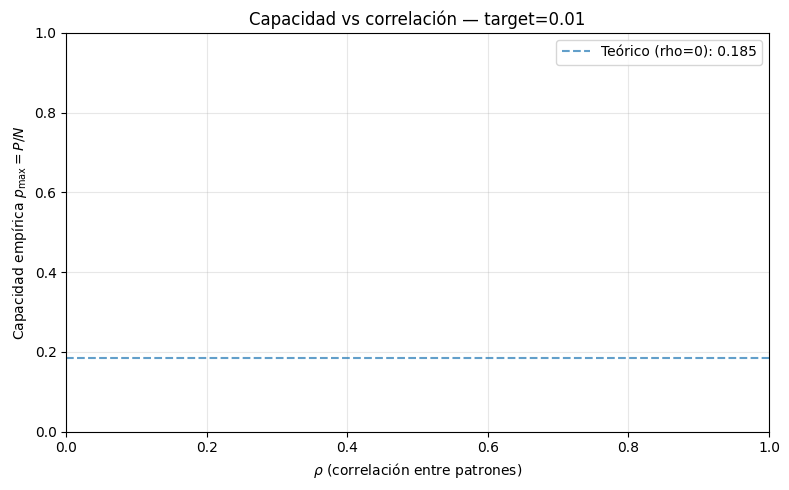

In [ ]:
import numpy as np

target = 0.01
THEORETICAL = {
    0.001: 0.105,
    0.0036: 0.138,
    0.01: 0.185,
    0.05: 0.37,
    0.1: 0.61
}
p_teo_ref = THEORETICAL.get(target, None)

P_range = {
    300: list(range(10, 500, 10)),
    600: list(range(10, 800, 10)),
    900: list(range(10, 1000, 10)),
}

Ns = []
Ns = [300, 600, 900]
rhos = np.linspace(0.0, 0.2, 15)  

for N in Ns:
    p_emp_list = capacidad_vs_rho(
        N=N,
        rhos=rhos,
        P_values=P_range[N],
        target=target,
        trials=3,
        norm='N',
        seed_base=1234
    )
    plot_capacidad_vs_rho(
        rhos,
        p_emp_list,
        target=target,
        p_teo_ref=p_teo_ref,
        title_extra=fr"$N={N}$"
    )

# Gráfico combinado
res_multi = capacidad_multiN_vs_rho(
    Ns,
    rhos,
    P_range_dict=P_range,
    target=target,
    trials=3,
    norm='N',
    seed_base=1234
)
plot_multiN_capacidad_vs_rho(rhos, res_multi, target=target, p_teo_ref=p_teo_ref)


### Conclusión

Los experimentos muestran de manera consistente que la **capacidad de almacenamiento** de la red de Hopfield disminuye cuando aumenta la **correlación entre patrones**.  

- Para $\rho \approx 0$ (patrones independientes), la capacidad empírica se acerca al valor **teórico máximo** ($p_{\max} \simeq 0.185$ para $N \to \infty$, con error target = 0.01).  
- A medida que crece $\rho$, la capacidad cae de forma **casi lineal**, indicando que los patrones dejan de aportar información independiente y generan **crosstalk local** más fuerte.  
- El efecto se observa en todos los tamaños $N$ probados (300, 600, 900): si bien con $N$ mayor la estimación es más estable, la **tendencia decreciente con $\rho$** se mantiene.  

En síntesis, la presencia de **correlación reduce la diversidad efectiva de los patrones** y por lo tanto disminuye la fracción $P/N$ que puede ser almacenada sin pérdida de estabilidad. Este resultado es coherente con la teoría y resalta que, para aplicaciones prácticas, es crucial considerar no solo la cantidad sino también la **independencia estadística** de los patrones a memorizar.


# 3. Implemente una red de Hopfield ‘82 que aprenda patrones pseudo-aleatorios y estudie qué sucede con los patrones aprendidos cuando algunas interconexiones son eliminadas al azar

### Función de poda de sinapsis

Para simular la eliminación aleatoria de conexiones en una red de Hopfield,
definimos la función `podar_sinapsis_simple`.

La idea es que cada interconexión se elimine
independientemente con probabilidad \(p\).

- Si la conexión se elimina → se asigna:
  $$
  W_{ij} = W_{ji} = 0
  $$
- Se mantiene siempre la **simetría** de la matriz de pesos.
- La **diagonal** se fuerza a cero, ya que no existen auto-conexiones.


In [24]:
def podar_sinapsis_simple(W, p, seed=None):
    """
    Poda simétrica de la matriz de pesos de Hopfield.

    Parámetros
    ----------
    W : ndarray (N,N)
        Matriz de pesos original.
    p : float
        Porcentaje de sinapsis a eliminar (0..1).
    seed : int | None
        Semilla para reproducibilidad.

    Retorna
    -------
    W_podada : ndarray (N,N)
        Matriz de pesos podada, simétrica y con diagonal 0.
    """
    W = np.asarray(W)
    N = W.shape[0]
    rng = np.random.default_rng(seed)
    
    # Índices de la parte superior triangular sin la diagonal
    iu = np.triu_indices(N, k=1)
    
    # Crear máscara de poda: True = mantener, False = eliminar
    mask_up = rng.random(iu[0].size) >= p
    
    # Crear máscara completa simétrica
    mask = np.zeros((N, N), dtype=bool)
    mask[iu] = mask_up
    mask = mask | mask.T
    
    # Aplicar máscara a la matriz de pesos
    W_podada = W.copy()
    W_podada *= mask.astype(W.dtype)
    np.fill_diagonal(W_podada, 0.0)
    
    return W_podada


# 3.a. ¿Cómo cambia el error en función del porcentaje de sinapsis eliminadas?


--- Tamaño 50x50, P=40 patrones ---
p=  0% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 10% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 30% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 50% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 70% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 80% | err_prom (prom/min/max) = 0.0002/0.0001/0.0003
p= 85% | err_prom (prom/min/max) = 0.0011/0.0010/0.0012
p= 90% | err_prom (prom/min/max) = 0.0066/0.0063/0.0073
p= 95% | err_prom (prom/min/max) = 0.0488/0.0481/0.0501
p= 98% | err_prom (prom/min/max) = 0.1653/0.1647/0.1663
p= 99% | err_prom (prom/min/max) = 0.2348/0.2325/0.2404


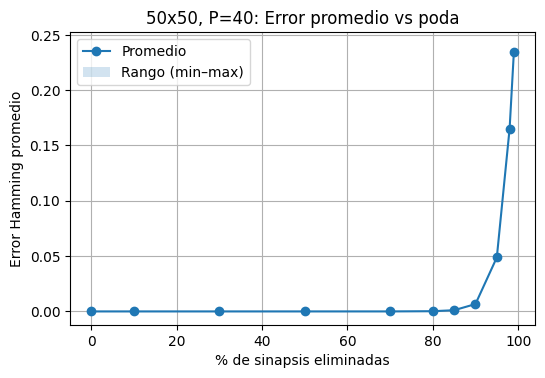


--- Tamaño 50x50, P=60 patrones ---
p=  0% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 10% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 30% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 50% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 70% | err_prom (prom/min/max) = 0.0002/0.0002/0.0003
p= 80% | err_prom (prom/min/max) = 0.0020/0.0017/0.0021
p= 85% | err_prom (prom/min/max) = 0.0072/0.0069/0.0075
p= 90% | err_prom (prom/min/max) = 0.0269/0.0260/0.0283
p= 95% | err_prom (prom/min/max) = 0.1099/0.1070/0.1127
p= 98% | err_prom (prom/min/max) = 0.2239/0.2222/0.2256
p= 99% | err_prom (prom/min/max) = 0.2732/0.2708/0.2750


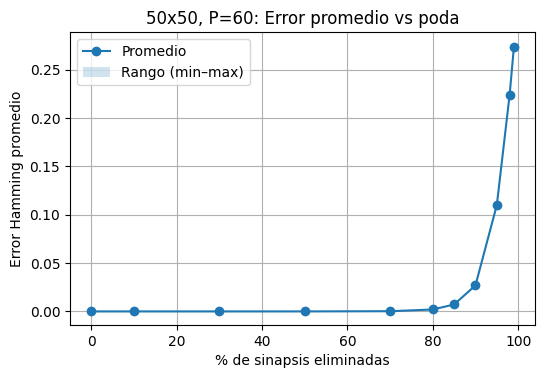


--- Tamaño 50x50, P=100 patrones ---
p=  0% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 10% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 30% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 50% | err_prom (prom/min/max) = 0.0002/0.0002/0.0002
p= 70% | err_prom (prom/min/max) = 0.0035/0.0034/0.0036
p= 80% | err_prom (prom/min/max) = 0.0175/0.0170/0.0181
p= 85% | err_prom (prom/min/max) = 0.0421/0.0403/0.0439
p= 90% | err_prom (prom/min/max) = 0.1025/0.0987/0.1059
p= 95% | err_prom (prom/min/max) = 0.1975/0.1957/0.2007
p= 98% | err_prom (prom/min/max) = 0.2764/0.2751/0.2778
p= 99% | err_prom (prom/min/max) = 0.3089/0.3076/0.3108


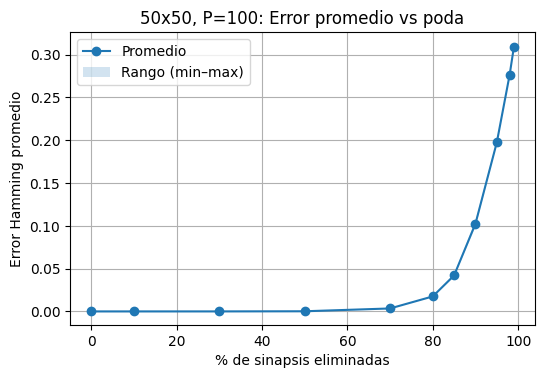

In [26]:
# Parámetros generales
porcentajes = [0, 10, 30, 50, 70, 80, 85, 90, 95, 98, 99]
ensayos_por_p = 5
rng_global = np.random.default_rng(123)

# Combinaciones lógicas: (filas, columnas, cantidad de patrones)
combinaciones = [
    (50, 50, [40, 60, 100]),

]

for filas, columnas, P_values in combinaciones:
    N = filas * columnas
    for P in P_values:
        print(f"\n--- Tamaño {filas}x{columnas}, P={P} patrones ---")
        # Generar patrones pseudoaleatorios
        X = generar_patrones_aleatorios(N, P, valores='pm1', seed=int(rng_global.integers(0, 1<<31)))
        W = entrenar_red_hopfield(X, norm='N')

        # Inicializar resultados
        res = {'p(%)': [], 'err_prom': [], 'err_min': [], 'err_max': []}

        for p in porcentajes:
            errprom_list = []
            for _ in range(ensayos_por_p):
                Wp = podar_sinapsis_simple(W, p/100.0, seed=int(rng_global.integers(0, 1<<31)))
                errores = []
                for i in range(P):
                    rec = recuperar_patron(X[i], Wp, max_iter=10000, rng=rng_global)
                    dif = np.count_nonzero(rec != X[i])
                    errores.append(dif / N)
                errprom_list.append(float(np.mean(errores)))

            er_arr = np.array(errprom_list, float)
            res['p(%)'].append(p)
            res['err_prom'].append(float(er_arr.mean()))
            res['err_min'].append(float(er_arr.min()))
            res['err_max'].append(float(er_arr.max()))
            print(f"p={p:>3}% | err_prom (prom/min/max) = {er_arr.mean():.4f}/{er_arr.min():.4f}/{er_arr.max():.4f}")

        # Graficar error Hamming promedio vs % poda
        plt.figure(figsize=(6, 3.8))
        x = res['p(%)']
        y = res['err_prom']
        ymin = res['err_min']
        ymax = res['err_max']
        plt.plot(x, y, marker='o', label='Promedio')
        plt.fill_between(x, ymin, ymax, alpha=0.2, label='Rango (min–max)')
        plt.xlabel('% de sinapsis eliminadas')
        plt.ylabel('Error Hamming promedio')
        plt.title(f'{filas}x{columnas}, P={P}: Error promedio vs poda')
        plt.grid(True)
        plt.legend()
        plt.show()


### 50×50

- Con **P = 40 patrones**:  
  - Hasta **p = 90%** de sinapsis eliminadas, la red mantiene recuperaciones exactas y error prácticamente nulo.  
  - A **p = 95%** se observa un pequeño aumento del error (~4.9%) y degradación leve de recuperaciones.  
  - En **p = 98%**, el error promedio sube a ~16.5%, indicando que algunos patrones comienzan a fallar.  
  - En **p = 99%**, el error promedio alcanza ~23.5%, mostrando que la mayoría de los patrones no se recuperan exactamente.

- Con **P = 60 patrones**:  
  - Hasta **p = 90%**, el error promedio sigue bajo (<3%).  
  - A **p = 95%**, el error promedio aumenta a ~11%, marcando la degradación inicial.  
  - En **p = 98%**, el error promedio es ~22%, y en **p = 99%**, ~27%.

- Con **P = 100 patrones**:  
  - Hasta **p = 85%**, la red mantiene error bajo (<4%).  
  - La degradación comienza más temprano: a **p = 90%**, el error ya es ~10%.  
  - En **p = 95%**, el error promedio llega a ~20%, y en **p = 98–99%**, alcanza ~28–31%.

### Conclusión

- La red de Hopfield para **50×50** mantiene alta tolerancia a la poda: funciona sin problemas hasta eliminar **~85–90% de las sinapsis**, dependiendo de la cantidad de patrones.  
- La degradación se vuelve significativa a partir de **p = 95–98%**, aumentando el error promedio y reduciendo las recuperaciones exactas.  
- A medida que se incrementa **P**, la red se vuelve más sensible a la poda: con más patrones, los atractores comienzan a colapsar antes y el error medio crece más rápido.


# 3.b. ¿Cómo cambia la capacidad en función del porcentaje de sinapsis eliminadas?

- **Experimento:** para varios tamaños de red **N** y varios niveles de poda **p** (porcentaje de sinapsis eliminadas),
  entrenamos una Hopfield con **P** patrones aleatorios, **podamos** la matriz de pesos y
  medimos el **error** tras un **paso sincrónico** de actualización.

- **Capacidad empírica:** para cada umbral de error (por ejemplo 0.001, 0.0036, 0.01, 0.05, 0.1),
  buscamos el **máximo** número de patrones **P** que cumple el umbral y reportamos
  la capacidad como $p_{\text{emp}} = P/N$.

- **Barrido de poda:** repetimos lo anterior para distintos **p** (0%, 10%, …, 95%, 98%, 99%)
  para ver **cómo cae** la capacidad con la poda.

- **Comparación:** graficamos $p_{\text{emp}}$ **vs.** % de poda y lo comparamos con la
  **teoría clásica sin poda** (Hopfield ’82), mostrada como líneas horizontales de referencia.

- **Lectura:** si $p_{\text{emp}}$ se mantiene cerca de la línea teórica cuando $p$ es chico,
  la red es **robusta**; cuando $p_{\text{emp}}$ baja fuerte al aumentar **p**, vemos el
  **impacto de la poda** en la capacidad.



=== Capacidad vs Poda (N=300) ===
poda= 0%  ->  P_err=0.001: emp=0.067 | teo=0.105  |  P_err=0.0036: emp=0.133 | teo=0.138  |  P_err=0.01: emp=0.167 | teo=0.185  |  P_err=0.05: emp=0.367 | teo=0.370  |  P_err=0.1: emp=0.600 | teo=0.610
poda=10%  ->  P_err=0.001: emp=0.067 | teo=0.105  |  P_err=0.0036: emp=0.100 | teo=0.138  |  P_err=0.01: emp=0.167 | teo=0.185  |  P_err=0.05: emp=0.333 | teo=0.370  |  P_err=0.1: emp=0.533 | teo=0.610
poda=30%  ->  P_err=0.001: emp=0.067 | teo=0.105  |  P_err=0.0036: emp=0.067 | teo=0.138  |  P_err=0.01: emp=0.100 | teo=0.185  |  P_err=0.05: emp=0.233 | teo=0.370  |  P_err=0.1: emp=0.400 | teo=0.610
poda=50%  ->  P_err=0.001: emp=0.033 | teo=0.105  |  P_err=0.0036: emp=0.067 | teo=0.138  |  P_err=0.01: emp=0.067 | teo=0.185  |  P_err=0.05: emp=0.167 | teo=0.370  |  P_err=0.1: emp=0.300 | teo=0.610
poda=70%  ->  P_err=0.001: emp=--  | teo=0.105  |  P_err=0.0036: emp=0.033 | teo=0.138  |  P_err=0.01: emp=0.033 | teo=0.185  |  P_err=0.05: emp=0.100 | teo=

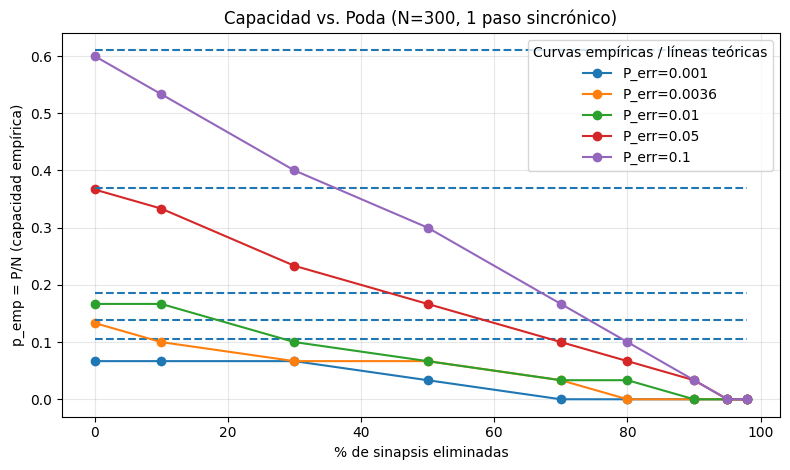


=== Capacidad vs Poda (N=600) ===
poda= 0%  ->  P_err=0.001: emp=0.100 | teo=0.105  |  P_err=0.0036: emp=0.133 | teo=0.138  |  P_err=0.01: emp=0.183 | teo=0.185  |  P_err=0.05: emp=0.367 | teo=0.370  |  P_err=0.1: emp=0.600 | teo=0.610
poda=10%  ->  P_err=0.001: emp=0.083 | teo=0.105  |  P_err=0.0036: emp=0.117 | teo=0.138  |  P_err=0.01: emp=0.167 | teo=0.185  |  P_err=0.05: emp=0.333 | teo=0.370  |  P_err=0.1: emp=0.550 | teo=0.610
poda=30%  ->  P_err=0.001: emp=0.067 | teo=0.105  |  P_err=0.0036: emp=0.083 | teo=0.138  |  P_err=0.01: emp=0.117 | teo=0.185  |  P_err=0.05: emp=0.250 | teo=0.370  |  P_err=0.1: emp=0.417 | teo=0.610
poda=50%  ->  P_err=0.001: emp=0.050 | teo=0.105  |  P_err=0.0036: emp=0.067 | teo=0.138  |  P_err=0.01: emp=0.083 | teo=0.185  |  P_err=0.05: emp=0.183 | teo=0.370  |  P_err=0.1: emp=0.300 | teo=0.610
poda=70%  ->  P_err=0.001: emp=0.033 | teo=0.105  |  P_err=0.0036: emp=0.033 | teo=0.138  |  P_err=0.01: emp=0.050 | teo=0.185  |  P_err=0.05: emp=0.100 | te

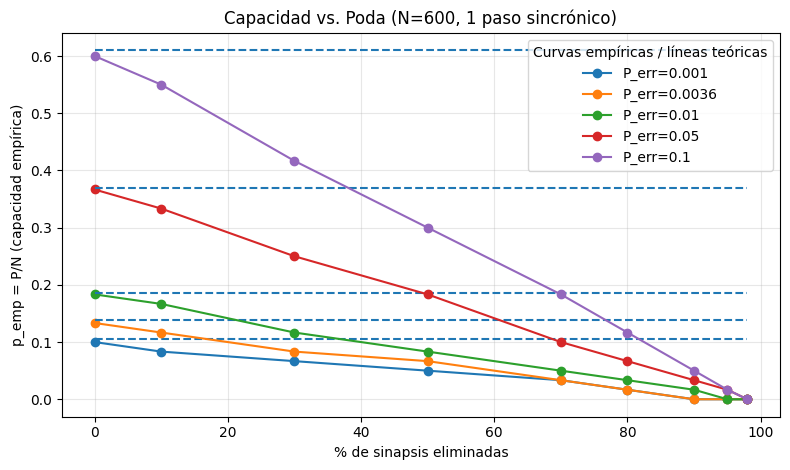


=== Capacidad vs Poda (N=900) ===
poda= 0%  ->  P_err=0.001: emp=0.100 | teo=0.105  |  P_err=0.0036: emp=0.133 | teo=0.138  |  P_err=0.01: emp=0.178 | teo=0.185  |  P_err=0.05: emp=0.367 | teo=0.370  |  P_err=0.1: emp=0.600 | teo=0.610
poda=10%  ->  P_err=0.001: emp=0.089 | teo=0.105  |  P_err=0.0036: emp=0.122 | teo=0.138  |  P_err=0.01: emp=0.167 | teo=0.185  |  P_err=0.05: emp=0.333 | teo=0.370  |  P_err=0.1: emp=0.544 | teo=0.610
poda=30%  ->  P_err=0.001: emp=0.067 | teo=0.105  |  P_err=0.0036: emp=0.089 | teo=0.138  |  P_err=0.01: emp=0.122 | teo=0.185  |  P_err=0.05: emp=0.256 | teo=0.370  |  P_err=0.1: emp=0.422 | teo=0.610
poda=50%  ->  P_err=0.001: emp=0.044 | teo=0.105  |  P_err=0.0036: emp=0.067 | teo=0.138  |  P_err=0.01: emp=0.089 | teo=0.185  |  P_err=0.05: emp=0.178 | teo=0.370  |  P_err=0.1: emp=0.300 | teo=0.610
poda=70%  ->  P_err=0.001: emp=0.022 | teo=0.105  |  P_err=0.0036: emp=0.033 | teo=0.138  |  P_err=0.01: emp=0.056 | teo=0.185  |  P_err=0.05: emp=0.111 | te

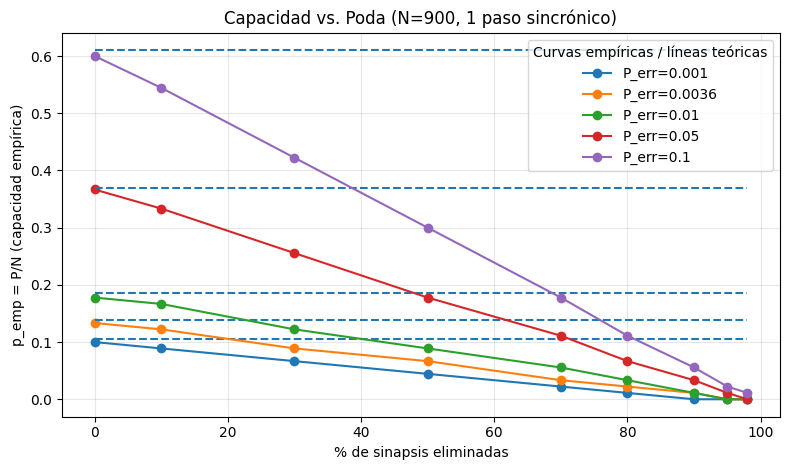

In [27]:
def experimento_simple_podado(
    N, P_values, podas, trials=3,
    targets=(0.001, 0.0036, 0.01, 0.05, 0.1),
    norm='N',
    patrones_source=None,
    seed_base=1234
):
   
    def _to_pm1(X):
        X = np.asarray(X)
        U = set(np.unique(X).tolist())
        if U.issubset({0, 1}):
            X = (X.astype(np.int8) * 2 - 1)
        elif not U.issubset({-1, 1}):
            X = np.where(X > 0, 1, -1).astype(np.int8)
        return X.astype(np.int8, copy=False)

    def _get_patrones(N, P, trial, seed):
        if callable(patrones_source):
            X0 = patrones_source(N, P, trial)
        elif isinstance(patrones_source, dict):
            pool = patrones_source.get(P, None)
            if pool is None:
                raise KeyError(f"No hay patrones para P={P} en patrones_source.")
            X0 = pool[trial % len(pool)] if isinstance(pool, (list, tuple)) else pool
        else:
            X0 = generar_patrones_aleatorios(
                N, P, seed=seed, valores='pm1', return_type='ndarray', dtype=np.int8
            )
        X0 = _to_pm1(X0)
        if X0.shape != (P, N):
            raise ValueError(f"Shape esperado ({P},{N}) y obtuve {X0.shape} para P={P}.")
        return X0

    resultados_por_poda = {}

    for poda in podas:
        mean_errors = []
        for P in P_values:
            errs = []
            for t in range(trials):
                seed = seed_base + 1000 * P + 10_000 * int(poda*1000) + t
                X0 = _get_patrones(N, P, trial=t, seed=seed)
                W  = entrenar_red_hopfield(X0, norm=norm)
                Wp = podar_sinapsis_simple(W, poda, seed=seed+7)  
                X_new = signo_binario(X0 @ Wp)                    
                errores_bits = np.count_nonzero(X_new != X0)
                errs.append(errores_bits / (P * N))
            mean_errors.append(float(np.mean(errs)))

    
        out = []
        for target in targets:
            last_ok = None
            for P, err in zip(P_values, mean_errors):
                if err <= target:
                    last_ok = (P, err)
            if last_ok:
                P_ok, err_ok = last_ok
                out.append((target, P_ok / N, err_ok))
            else:
                out.append((target, None, None))
        resultados_por_poda[poda] = out

    return resultados_por_poda

def plot_cap_vs_poda(N, resultados_por_poda, theoretical):
    """
    Un gráfico por N: líneas de p_emp (y) vs poda (x) para cada P_error target.
    Línea horizontal = p_teo (sin poda) para referencia.
    """
    podas = sorted(resultados_por_poda.keys())
    targets = [t for (t, _, _) in resultados_por_poda[podas[0]]]

    plt.figure(figsize=(8, 4.8))
    for t in targets:
        y = []
        for p in podas:
            triplets = resultados_por_poda[p]
            for (tt, p_emp, _) in triplets:
                if tt == t:
                    y.append(0.0 if p_emp is None else p_emp)
                    break
        plt.plot([int(100*p) for p in podas], y, marker='o', label=f"P_err={t:.4g}")
        plt.hlines(theoretical[t], xmin=int(100*podas[0]), xmax=int(100*podas[-1]), linestyles='dashed')

    plt.xlabel('% de sinapsis eliminadas')
    plt.ylabel('p_emp = P/N (capacidad empírica)')
    plt.title(f"Capacidad vs. Poda (N={N}, 1 paso sincrónico)")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Curvas empíricas / líneas teóricas")
    plt.tight_layout()
    plt.show()

THEORETICAL = { 
    0.001: 0.105,
    0.0036: 0.138,
    0.01: 0.185,
    0.05: 0.37,
    0.1: 0.61,
}

P_range = {
    300:  list(range(10, 500, 10)),
    600:  list(range(10, 800, 10)),
    900:  list(range(10, 1000, 10)),
}
Ns = list(P_range.keys())


PODAS = [0.0, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 0.98]

for N in Ns:
    res_podado = experimento_simple_podado(
        N=N,
        P_values=P_range[N],
        podas=PODAS,
        trials=3,
        targets=tuple(THEORETICAL.keys()),
        norm='N',
        patrones_source=None,  
        seed_base=1234
    )

    print(f"\n=== Capacidad vs Poda (N={N}) ===")
    for poda in PODAS:
        triples = res_podado[poda]
        cols = []
        for t, p_emp, err in triples:
            p_teo = THEORETICAL[t]
            if p_emp is None:
                cols.append(f"P_err={t:.4g}: emp=--  | teo={p_teo:.3f}")
            else:
                cols.append(f"P_err={t:.4g}: emp={p_emp:.3f} | teo={p_teo:.3f}")
        print(f"poda={int(100*poda):>2d}%  ->  " + "  |  ".join(cols))

    plot_cap_vs_poda(N, res_podado, THEORETICAL)


## Conclusiones: capacidad vs. poda de sinapsis (N = 300, 600, 900)

**Qué comparamos:** capacidad empírica $p_{\text{emp}} = P/N$ (1 paso sincrónico) para distintos umbrales de error $P_{\text{error}}$ y niveles de poda ($0\text{–}98\%$), frente a la **teoría sin poda**.

### Sin poda (0%)
- Los valores empíricos están **muy cerca** de la teoría, especialmente para $N=600$ y $N=900$.
- Para $N=300$, hay una ligera subestimación en el umbral más estricto ($P_{\text{error}}=0.001$).

### Efecto de la poda (tendencia general)
- La capacidad **disminuye aproximadamente de manera lineal** a medida que aumenta el porcentaje de sinapsis eliminadas hasta cierto punto.
- Los umbrales de error más estrictos ($0.001$, $0.0036$) **pierden capacidad antes** que los más relajados ($0.05$, $0.1$).
- A partir de **$70\text{–}80\%$** de poda, la caída se vuelve **más pronunciada** y se acerca al colapso total.

### Comparación por tamaño de red (robustez)
- **Redes más grandes son más tolerantes**: a igual porcentaje de poda, $N=900$ conserva más capacidad que $N=600$, y ambos más que $N=300$.
  - A **$90\%$** de poda y $P_{\text{error}}=0.1$:
    - $N=300$: $p_{\text{emp}}\approx 0.033$
    - $N=600$: $p_{\text{emp}}\approx 0.050$
    - $N=900$: $p_{\text{emp}}\approx 0.056$
  - A **$95\%$** de poda y $P_{\text{error}}=0.1$:
    - $N=300$: sin capacidad
    - $N=600$: $p_{\text{emp}}\approx 0.017$
    - $N=900$: $p_{\text{emp}}\approx 0.022$
  - A **$98\%$** de poda y $P_{\text{error}}=0.1$:
    - $N=300,600$: sin capacidad
    - $N=900$: $p_{\text{emp}}\approx 0.011$

### Conclusión
- Con **poda moderada** ($\le 50\%$), la red mantiene una fracción significativa de su capacidad, especialmente para umbrales más relajados.
- Para **poda alta** ($\ge 70\%$), la capacidad **cae casi linealmente** antes de desplomarse al acercarse al colapso total, y los **umbrales estrictos desaparecen primero**.
- En resumen: la poda reduce la capacidad, pero **redes más grandes son más tolerantes**, y la relación lineal parcial entre capacidad y % de sinapsis eliminadas se observa claramente antes del colapso.
